In [1]:
!pip install ta --break-system-packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize
from scipy.stats import norm

from hmmlearn import hmm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline

import ta
import requests
import json
import time
import os
import yfinance as yf

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 10

print("="*80)
print("ATTF Programming Assignment 3")
print("="*80)
print("\nAll packages imported successfully")

ATTF Programming Assignment 3

All packages imported successfully


In [3]:
from dotenv import load_dotenv
load_dotenv("FINANCE_API_KEYS.env")

POLYGON_API_KEY = os.getenv("POLYGON_API_KEY", "")
NEWS_API_KEY = os.getenv("NEWS_API_KEY", "")
FMP_API_KEY = os.getenv("FMP_API_KEY", "")
FRED_API_KEY = os.getenv("FRED_API_KEY", "")
QUIVER_API_KEY = os.getenv("QUIVER_API_KEY", "")

def _mask(k):
    return f"{k[:6]}...{k[-4:]}" if k and len(k) >= 12 else ("MISSING" if not k else k[:4]+"...")

print("API KEY VERIFICATION")
for name, val in {
    "Polygon.io": POLYGON_API_KEY,
    "News API": NEWS_API_KEY,
    "Financial Modeling Prep": FMP_API_KEY,
    "FRED": FRED_API_KEY,
    "Quiver Quant": QUIVER_API_KEY,
}.items():
    print(f"{name:25} {_mask(val)}")

API KEY VERIFICATION
Polygon.io                i0mFBg...eeT_
News API                  9c9435...2d90
Financial Modeling Prep   6BoEHq...P4jr
FRED                      e7ef83...8e66
Quiver Quant              37564e...7889


In [4]:
print("Setting portfolio universe")

ALL_TICKERS = {
    'AI Infrastructure': ['NVDA', 'AMD', 'MSFT', 'QCOM', 'CORW', 'NBIS', 'ORCL'],
    'Robotics and Space': ['TSLA', 'JOBY', 'RKLB', 'ASTS', 'BA'],
    'Cryptocurrencies': ['IREN', 'CORZ', 'IBIT', 'COIN', 'CLSK'],
    'Quantum': ['IONQ', 'RGTI', 'IBM', 'GOOG', 'HON']
}

FLAT_TICKERS = [t for sleeve in ALL_TICKERS.values() for t in sleeve]

SLEEVE_MAP = {}
for sleeve, tickers in ALL_TICKERS.items():
    for t in tickers:
        SLEEVE_MAP[t] = sleeve

SLEEVE_PROXIES = {
    'AI Infrastructure': ['QQQ'],
    'Robotics and Space': ['ITA'],
    'Cryptocurrencies': ['BTC-USD'],
    'Quantum': ['XLK'],
}

CHECKPOINT_A_SLEEVE_WEIGHTS = {
    'AI Infrastructure': 0.40,
    'Robotics and Space': 0.30,
    'Cryptocurrencies': 0.20,
    'Quantum': 0.10
}

PROXY_START = '1999-01-01'
START_DATE = '2013-01-01'
END_DATE = '2025-10-11'
TRADING_DAYS = 252

FEE_STRUCTURE = {
    "transaction_cost": 0.0015,
    "bid_ask_spread" : 0.0005,
    "management_fee_annual": 0.015,
    "short_borrow_rate_annual": 0.03,
}

FEE_STRUCTURE["management_fee_daily"] = FEE_STRUCTURE["management_fee_annual"] / TRADING_DAYS
FEE_STRUCTURE["short_borrow_rate_daily"] = FEE_STRUCTURE["short_borrow_rate_annual"] / TRADING_DAYS

RISK_FREE_RATE = 0.04

print("Universe size:", sum(len(v) for v in ALL_TICKERS.values()))
print("Sleeves", ", ".join(ALL_TICKERS.keys()))
print(f"Date range: {START_DATE} to {END_DATE}")

Setting portfolio universe
Universe size: 22
Sleeves AI Infrastructure, Robotics and Space, Cryptocurrencies, Quantum
Date range: 2013-01-01 to 2025-10-11


In [5]:
def fetch_polygon_dividends(ticker, start_date, end_date, api_key):
    url = f"https://api.polygon.io/v3/reference/dividends"

    params = {
        'ticker': ticker,
        'ex_dividend_date.gte': start_date,
        'ex_dividend_date.lte': end_date,
        'limit': 1000,
        'apiKey': api_key
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()

        if 'results' not in data or len(data['results']) == 0:
            return None

        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['ex_dividend_date'])
        df = df[['date', 'cash_amount']]
        df = df.set_index('date')
        df.columns = ['dividend']

        return df

    except Exception as e:
        return None

In [6]:
def fetch_polygon_data_with_dividends(ticker, start_date, end_date, api_key):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': 50000,
        'apiKey': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'results' not in data:
            print(f"[{ticker}] No data available")
            return None

        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['t'], unit='ms')
        df = df.set_index('date')[['c']]
        df.columns = ['price']

        div_df = fetch_polygon_dividends(ticker, start_date, end_date, api_key)
        
        if div_df is not None and len(div_df) > 0:
            df = df.join(div_df, how='left')
            df['dividend'] = df['dividend'].fillna(0)
            df['adj_price'] = df['price'].copy()
            
            for div_date in div_df.index:
                if div_date in df.index:
                    div_amount = div_df.loc[div_date, 'dividend']
                    price_at_div = df.loc[div_date, 'price']
                    adj_factor = 1 + (div_amount / price_at_div)
                    mask = df.index > div_date
                    df.loc[mask, 'adj_price'] *= adj_factor
            
            print(f"[{ticker}] {len(df)} days | {len(div_df)} dividends")
            return df[['adj_price']].rename(columns={'adj_price': ticker})
        else:
            print(f"[{ticker}] {len(df)} days | No dividends")
            return df[['price']].rename(columns={'price': ticker})
            
    except Exception as e:
        print(f"[{ticker}] Error: {str(e)}")
        return None

print("\n" + "="*80)
print("Downloading Dividend-Adjusted Data")
print("="*80 + "\n")

data_dict = {}

for ticker in FLAT_TICKERS:
    series = fetch_polygon_data_with_dividends(ticker, START_DATE, END_DATE, POLYGON_API_KEY)
    if series is not None:
        data_dict[ticker] = series
    time.sleep(0.15)



[NVDA] 2496 days | 51 dividends
[AMD] 2496 days | No dividends
[MSFT] 2496 days | 51 dividends
[QCOM] 2496 days | 51 dividends
[CORW] No data available
[NBIS] 244 days | No dividends
[ORCL] 2496 days | 50 dividends
[TSLA] 2496 days | No dividends
[JOBY] 1047 days | No dividends
[RKLB] 1037 days | No dividends
[ASTS] 1135 days | No dividends
[BA] 2496 days | 29 dividends
[IREN] 978 days | No dividends
[CORZ] 670 days | No dividends
[IBIT] 601 days | No dividends
[COIN] 1130 days | No dividends
[CLSK] 1436 days | No dividends
[IONQ] 1011 days | No dividends
[RGTI] 907 days | No dividends
[IBM] 2496 days | 51 dividends
[GOOG] 2496 days | 6 dividends
[HON] 2496 days | 51 dividends


In [7]:
print("\n" + "="*80)
print("Downloading SPY Benchmark")
print("="*80 + "\n")

spy_data = fetch_polygon_data_with_dividends('SPY', START_DATE, END_DATE, POLYGON_API_KEY)
if spy_data is not None:
    data_dict['SPY'] = spy_data

if len(data_dict) > 0:
    data_all = pd.concat([data_dict[ticker] for ticker in data_dict.keys()], 
                         axis=1, 
                         keys=data_dict.keys())
else:
    print("No data was downloaded!")
    data_all = pd.DataFrame()

print(f"\n{'='*80}")
print(f"DATA LOADED (DIVIDEND-ADJUSTED)")
print(f"{'='*80}")
print(f"Portfolio stocks: {len([c for c in data_all.columns if c != 'SPY'])}/{len(FLAT_TICKERS)}")
print(f"Benchmark: SPY")
print(f"Date range: {data_all.index[0].date()} to {data_all.index[-1].date()}")
print(f"Shape: {data_all.shape}")

missing = [t for t in FLAT_TICKERS if t not in data_all.columns]
if missing:
    print(f"\n Missing tickers: {', '.join(missing)}")
    print("These will be excluded from analysis.")

data_all = data_all.fillna(method='ffill').fillna(method='bfill')
min_stocks_required = len(data_all.columns) * 0.5
data_all = data_all.dropna(thresh=min_stocks_required)

print(f"\n After cleaning: {data_all.shape[0]} days with {data_all.shape[1]} assets")

spy_prices = data_all[['SPY']].copy()
data = data_all.drop('SPY', axis=1)



[SPY] 2496 days | 51 dividends

DATA LOADED (DIVIDEND-ADJUSTED)
Portfolio stocks: 22/22
Benchmark: SPY
Date range: 2015-11-06 to 2025-10-10
Shape: (2496, 22)

 Missing tickers: CORW
These will be excluded from analysis.

 After cleaning: 2496 days with 22 assets


In [8]:
print("\n" + "="*80)
print("Downloading Proxy Data (1999-Present)")
print("="*80 + "\n")

def load_proxy_prices(tickers, start=PROXY_START, end=END_DATE):
    try:
        px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']
        if isinstance(px, pd.Series):
            px = px.to_frame(tickers[0])
        px = px.dropna(how='all').ffill()
        return px
    except Exception as e:
        print(f"Error downloading {tickers}: {e}")
        return pd.DataFrame()

proxy_data = {}
for sleeve_name, tickers in SLEEVE_PROXIES.items():
    print(f"[{sleeve_name}] Downloading {', '.join(tickers)}...")
    px = load_proxy_prices(tickers, start=PROXY_START, end=END_DATE)
    if not px.empty:
        proxy_data[sleeve_name] = px.mean(axis=1)
        print(f" {len(px)} days")
    else:
        print(f"No data")

proxy_prices = pd.DataFrame(proxy_data).dropna(how='all')

print(f"\nProxy data loaded: {proxy_prices.shape[0]} days, {proxy_prices.shape[1]} sleeves")
print(f"Date range: {proxy_prices.index[0].date()} to {proxy_prices.index[-1].date()}")



[AI Infrastructure] Downloading QQQ...
 6690 days
[Robotics and Space] Downloading ITA...
 4890 days
[Cryptocurrencies] Downloading BTC-USD...
 4042 days
[Quantum] Downloading XLK...
 6735 days

Proxy data loaded: 7993 days, 4 sleeves
Date range: 1999-01-04 to 2025-10-10


In [9]:
print("\n" + "="*80)
print("Performance Helpers")
print("="*80)

TRADING_DAYS = 252

def ann_return(log_ret):
    n_days = len(log_ret)
    years = n_days / TRADING_DAYS

    total_log_return = log_ret.sum()

    total_return = np.exp(total_log_return) - 1

    cagr = (1 + total_return) ** (1 / years) - 1

    return cagr

def ann_vol(log_ret):
    return log_ret.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(log_ret, rf_annual=RISK_FREE_RATE):
    rf_daily = rf_annual / TRADING_DAYS
    excess_ret = (log_ret.mean() - rf_daily) * TRADING_DAYS
    vol = ann_vol(log_ret)
    return excess_ret / vol if vol > 0 else 0.0

def alpha_beta_calc(port_log_ret, bench_log_ret):
    aligned = pd.concat([port_log_ret, bench_log_ret], axis=1).dropna()
    if len(aligned) < 2:
        return np.nan, np.nan

    port = aligned.iloc[:, 0].values
    bench = aligned.iloc[:, 1].values
    cov_matrix = np.cov(port, bench)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]

    alpha = (np.mean(port) - beta * np.mean(bench)) * TRADING_DAYS

    return alpha, beta

def max_drawdown(log_ret):
    cum_ret = log_ret.cumsum()
    wealth = np.exp(cum_ret)
    running_max = wealth.cummax()
    drawdown = (wealth / running_max - 1.0)
    return drawdown.min()

print("Performance helpers defined")


Performance Helpers
Performance helpers defined


In [10]:
print("\n" + "="*80)
print("Calculating Log Returns")
print("="*80)

returns = np.log(data / data.shift(1)).dropna()
print(f"\nPortfolio log returns: {returns.shape}")

spy_returns = np.log(spy_prices / spy_prices.shift(1)).dropna()
print(f"SPY log returns: {spy_returns.shape}")

proxy_returns = np.log(proxy_prices /proxy_prices.shift(1)).dropna()
print(f"Proxy log returns: {proxy_returns.shape}")


Calculating Log Returns

Portfolio log returns: (2495, 21)
SPY log returns: (2495, 1)
Proxy log returns: (2178, 4)


In [11]:
print("\n" + "="*80)
print("Calculating Sleeve Returns")
print("="*80)

sleeve_returns = pd.DataFrame()

for sleeve_name, tickers in ALL_TICKERS.items():
    available_tickers = [t for t in tickers if t in returns.columns]
    
    if len(available_tickers) == 0:
        print(f"\n {sleeve_name}: No data available")
        continue

    sleeve_returns[sleeve_name] = returns[available_tickers].mean(axis=1)

    missing_in_sleeve = set(tickers) - set(available_tickers)
    if missing_in_sleeve:
        print(f"\n{sleeve_name}:")
        print(f"  Available: {', '.join(available_tickers)}")
        print(f"  Missing: {', '.join(missing_in_sleeve)}")
    else:
        print(f"\n{sleeve_name}: All {len(tickers)} stocks available")

print(f"\nCalculated sleeve returns for {len(sleeve_returns.columns)} sleeves")
print(f"  Shape: {sleeve_returns.shape}")


Calculating Sleeve Returns

AI Infrastructure:
  Available: NVDA, AMD, MSFT, QCOM, NBIS, ORCL
  Missing: CORW

Robotics and Space: All 5 stocks available

Cryptocurrencies: All 5 stocks available

Quantum: All 5 stocks available

Calculated sleeve returns for 4 sleeves
  Shape: (2495, 4)


In [12]:
print("\n" + "="*80)
print("Proxy Sleeve Returns (1999-PRESENT)")
print("="*80)

print(f"\nProxy sleeve performance (annualized):")
for sleeve in proxy_returns.columns:
    ret = ann_return(proxy_returns[sleeve])
    vol = ann_vol(proxy_returns[sleeve])
    sr = sharpe_ratio(proxy_returns[sleeve])
    print(f"  {sleeve}:")
    print(f"    Return: {ret:.2%}, Vol: {vol:.2%}, Sharpe: {sr:.3f}")


Proxy Sleeve Returns (1999-PRESENT)

Proxy sleeve performance (annualized):
  AI Infrastructure:
    Return: 17.67%, Vol: 21.78%, Sharpe: 0.563
  Robotics and Space:
    Return: 16.53%, Vol: 21.53%, Sharpe: 0.525
  Cryptocurrencies:
    Return: 28.21%, Vol: 61.23%, Sharpe: 0.341
  Quantum:
    Return: 21.76%, Vol: 23.38%, Sharpe: 0.671


In [13]:
print("Downloading FRED macro features...")

def fred_series(series_id, start=PROXY_START, end=END_DATE, api_key=os.getenv("FRED_API_KEY","")):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start,
        "observation_end": end,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()
    if "observations" not in js or not js["observations"]:
        return pd.Series(dtype="float64", name=series_id)

    df = pd.DataFrame(js["observations"])
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    s = df.set_index("date")["value"].rename(series_id)

    daily_index = pd.date_range(start=start, end=end, freq="D")
    return s.reindex(daily_index).ffill()

macro = pd.DataFrame(index=pd.date_range(start=PROXY_START, end=END_DATE, freq="D"))

to_pull = [
    "UNRATE",   
    "DFF",       
    "VIXCLS",    
    "DGS10",    
    "DGS2",      
    "CPIAUCSL",  
    "INDPRO",    
]

for sid in to_pull:
    try:
        macro[sid] = fred_series(sid)
    except Exception as e:
        print(f" WARN: {sid} failed: {e}")
        macro[sid] = np.nan

macro = macro.loc[pd.to_datetime(START_DATE):pd.to_datetime(END_DATE)].ffill()

macro["yield_curve"] = macro["DGS10"] - macro["DGS2"]
macro["cpi_yoy"]     = macro["CPIAUCSL"].pct_change(365)    
macro["indprod_yoy"] = macro["INDPRO"].pct_change(365)

macro = macro[[
    "UNRATE", "DFF", "VIXCLS", "yield_curve", "cpi_yoy", "indprod_yoy"
]]

print("Macro loaded:", macro.shape)
print("Coverage (non-null share):")
print(macro.notna().mean().round(3))

Macro loaded: (4667, 6)
Coverage (non-null share):
UNRATE         1.000
DFF            1.000
VIXCLS         1.000
yield_curve    1.000
cpi_yoy        0.922
indprod_yoy    0.922
dtype: float64


In [14]:
spy_series = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
spy_series.index = pd.to_datetime(spy_series.index).normalize()
macro.index = pd.to_datetime(macro.index).normalize()

spy_series = spy_series.loc[(spy_series.index >= pd.to_datetime(START_DATE)) & 
                            (spy_series.index <= pd.to_datetime(END_DATE))]

hmm_features = pd.DataFrame(index=spy_series.index)
hmm_features["spy_ret"] = spy_series
hmm_features["spy_vol20"] = spy_series.rolling(20).std() * np.sqrt(TRADING_DAYS)

macro_aligned = macro.reindex(hmm_features.index).ffill()
hmm_features = hmm_features.join(macro_aligned)

hmm_features = hmm_features.dropna()

print("\nHMM feature frame ready")
print("Shape:", hmm_features.shape)
print("Columns:", list(hmm_features.columns))
print("Sample:\n", hmm_features.head(5))


hmm_features = pd.DataFrame(index=spy_series.index)
hmm_features["spy_ret"]   = spy_series
hmm_features["spy_vol20"] = spy_series.rolling(20).std() * np.sqrt(TRADING_DAYS)

macro_aligned = macro.reindex(hmm_features.index).ffill()

hmm_features = hmm_features.join(macro_aligned[[
    "yield_curve", "DFF", "UNRATE", "VIXCLS", "cpi_yoy", "indprod_yoy"
]])

hmm_features = hmm_features.dropna().copy()

print("\nHMM feature frame ready")
print("Shape:", hmm_features.shape)
print("Columns:", list(hmm_features.columns))
print("Sample:")
print(hmm_features.head())


HMM feature frame ready
Shape: (2476, 8)
Columns: ['spy_ret', 'spy_vol20', 'UNRATE', 'DFF', 'VIXCLS', 'yield_curve', 'cpi_yoy', 'indprod_yoy']
Sample:
              spy_ret  spy_vol20  UNRATE   DFF  VIXCLS  yield_curve   cpi_yoy  \
date                                                                           
2015-12-07 -0.006077   0.152201     5.0  0.13   15.84         1.29  0.006387   
2015-12-08 -0.006747   0.150422     5.0  0.13   17.60         1.30  0.006387   
2015-12-09 -0.007805   0.152393     5.0  0.14   19.61         1.29  0.006387   
2015-12-10  0.002578   0.152355     5.0  0.14   19.34         1.29  0.006387   
2015-12-11 -0.019571   0.159953     5.0  0.14   24.39         1.25  0.006387   

            indprod_yoy  
date                     
2015-12-07    -0.045051  
2015-12-08    -0.045051  
2015-12-09    -0.045051  
2015-12-10    -0.045051  
2015-12-11    -0.045051  

HMM feature frame ready
Shape: (2476, 8)
Columns: ['spy_ret', 'spy_vol20', 'yield_curve', 'DFF', 'UNRAT

In [15]:
print("Checking spy_prices:")
print(f"Type: {type(spy_prices)}")
print(f"Shape: {spy_prices.shape}")
print(f"Columns: {spy_prices.columns.tolist() if hasattr(spy_prices, 'columns') else 'N/A'}")
print(f"\nFirst 5 rows:")
print(spy_prices.head())

Checking spy_prices:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (2496, 1)
Columns: [('SPY', 'SPY')]

First 5 rows:
                        SPY
                        SPY
date                       
2015-11-06 05:00:00  210.04
2015-11-09 05:00:00  208.08
2015-11-10 05:00:00  208.56
2015-11-11 05:00:00  207.74
2015-11-12 05:00:00  204.84


In [16]:
print("Extracting SPY price series:")
spy_price = spy_prices['SPY']
print(f"Type: {type(spy_price)}")
print(f"Shape: {spy_price.shape}")
print(f"Has NaNs: {spy_price.isna().sum()}")
print(f"\nFirst 5 values:")
print(spy_price.head())

Extracting SPY price series:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (2496, 1)
Has NaNs: SPY    0
dtype: int64

First 5 values:
                        SPY
date                       
2015-11-06 05:00:00  210.04
2015-11-09 05:00:00  208.08
2015-11-10 05:00:00  208.56
2015-11-11 05:00:00  207.74
2015-11-12 05:00:00  204.84


In [17]:
print("Testing pct_change(20) on spy_price:")
spy_ret_20d = spy_price.pct_change(20)
print(f"Result shape: {spy_ret_20d.shape}")
print(f"NaN count: {spy_ret_20d.isna().sum()}")
print(f"Non-NaN count: {(~spy_ret_20d.isna()).sum()}")
print(f"\nFirst 25 values:")
print(spy_ret_20d.head(25))

Testing pct_change(20) on spy_price:
Result shape: (2496, 1)
NaN count: SPY    20
dtype: int64
Non-NaN count: SPY    2476
dtype: int64

First 25 values:
                          SPY
date                         
2015-11-06 05:00:00       NaN
2015-11-09 05:00:00       NaN
2015-11-10 05:00:00       NaN
2015-11-11 05:00:00       NaN
2015-11-12 05:00:00       NaN
2015-11-13 05:00:00       NaN
2015-11-16 05:00:00       NaN
2015-11-17 05:00:00       NaN
2015-11-18 05:00:00       NaN
2015-11-19 05:00:00       NaN
2015-11-20 05:00:00       NaN
2015-11-23 05:00:00       NaN
2015-11-24 05:00:00       NaN
2015-11-25 05:00:00       NaN
2015-11-27 05:00:00       NaN
2015-11-30 05:00:00       NaN
2015-12-01 05:00:00       NaN
2015-12-02 05:00:00       NaN
2015-12-03 05:00:00       NaN
2015-12-04 05:00:00       NaN
2015-12-07 05:00:00 -0.008046
2015-12-08 05:00:00 -0.005435
2015-12-09 05:00:00 -0.015439
2015-12-10 05:00:00 -0.009002
2015-12-11 05:00:00 -0.014450


In [18]:
print("Extract SPY as true Series")
spy_price_series = spy_prices['SPY'].squeeze()  
print(f"Type after squeeze: {type(spy_price_series)}")
print(f"Shape: {spy_price_series.shape}")

print("\nCalculate 20-day return BEFORE reindexing")
spy_ret_20d = spy_price_series.pct_change(20)
print(f"spy_ret_20d type: {type(spy_ret_20d)}")
print(f"Non-NaN values: {(~spy_ret_20d.isna()).sum()}")

print("\nAlign with hmm_features index")
spy_ret_20d_aligned = spy_ret_20d.reindex(hmm_features.index)
print(f"After reindex type: {type(spy_ret_20d_aligned)}")
print(f"After reindex non-NaN: {(~spy_ret_20d_aligned.isna()).sum()}")
print(f"Values > 0: {(spy_ret_20d_aligned > 0).sum()}")

print("\nCalculate MA50")
spy_ma50 = spy_price_series.rolling(50).mean().reindex(hmm_features.index)
spy_price_aligned = spy_price_series.reindex(hmm_features.index)

print(f"\nCheck price > MA50 condition")
price_above_ma = spy_price_aligned > spy_ma50
print(f"Days where price > MA50: {price_above_ma.sum()}")

Extract SPY as true Series
Type after squeeze: <class 'pandas.core.series.Series'>
Shape: (2496,)

Calculate 20-day return BEFORE reindexing
spy_ret_20d type: <class 'pandas.core.series.Series'>
Non-NaN values: 2476

Align with hmm_features index
After reindex type: <class 'pandas.core.series.Series'>
After reindex non-NaN: 0
Values > 0: 0

Calculate MA50

Check price > MA50 condition
Days where price > MA50: 0


In [19]:
print("Checking index compatibility:")
print(f"\nspy_price_series.index type: {type(spy_price_series.index)}")
print(f"spy_price_series.index[0]: {spy_price_series.index[0]}")
print(f"spy_price_series.index[-1]: {spy_price_series.index[-1]}")

print(f"\nhmm_features.index type: {type(hmm_features.index)}")
print(f"hmm_features.index[0]: {hmm_features.index[0]}")
print(f"hmm_features.index[-1]: {hmm_features.index[-1]}")

print(f"\nDo indices overlap?")
print(f"Common dates: {len(set(spy_price_series.index) & set(hmm_features.index))}")

print(f"\nFirst 5 dates in spy_price_series.index:")
print(spy_price_series.index[:5])

print(f"\nFirst 5 dates in hmm_features.index:")
print(hmm_features.index[:5])

Checking index compatibility:

spy_price_series.index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
spy_price_series.index[0]: 2015-11-06 05:00:00
spy_price_series.index[-1]: 2025-10-10 04:00:00

hmm_features.index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
hmm_features.index[0]: 2015-12-07 00:00:00
hmm_features.index[-1]: 2025-10-10 00:00:00

Do indices overlap?
Common dates: 0

First 5 dates in spy_price_series.index:
DatetimeIndex(['2015-11-06 05:00:00', '2015-11-09 05:00:00',
               '2015-11-10 05:00:00', '2015-11-11 05:00:00',
               '2015-11-12 05:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

First 5 dates in hmm_features.index:
DatetimeIndex(['2015-12-07', '2015-12-08', '2015-12-09', '2015-12-10',
               '2015-12-11'],
              dtype='datetime64[ns]', name='date', freq=None)


In [20]:
print("Normalizing indices to remove time components:")

spy_price_series.index = pd.to_datetime(spy_price_series.index).normalize()
print(f"spy_price_series.index[0]: {spy_price_series.index[0]}")
print(f"spy_price_series.index[-1]: {spy_price_series.index[-1]}")

print(f"\nhmm_features.index[0]: {hmm_features.index[0]}")
print(f"\nhmm_features.index[-1]: {hmm_features.index[-1]}")

spy_ret_20d = spy_price_series.pct_change(20)
spy_ret_20d_aligned = spy_ret_20d.reindex(hmm_features.index)

print(f"\nAfter normalization and reindex:")
print(f"Common dates: {len(set(spy_price_series.index) & set(hmm_features.index))}")
print(f"spy_ret_20d_aligned non-NaN: {(~spy_ret_20d_aligned.isna()).sum()}")
print(f"spy_ret_20d_aligned > 0: {(spy_ret_20d_aligned > 0).sum()}")

Normalizing indices to remove time components:
spy_price_series.index[0]: 2015-11-06 00:00:00
spy_price_series.index[-1]: 2025-10-10 00:00:00

hmm_features.index[0]: 2015-12-07 00:00:00

hmm_features.index[-1]: 2025-10-10 00:00:00

After normalization and reindex:
Common dates: 2476
spy_ret_20d_aligned non-NaN: 2476
spy_ret_20d_aligned > 0: 1688


In [21]:
print("\n" + "="*80)
print("Final Regime Classification")
print("="*80)

if isinstance(spy_prices, pd.DataFrame) and 'SPY' in spy_prices.columns:
    spy_prices_series = spy_prices['SPY'].copy()
else:
    spy_price_series = spy_prices.copy()

spy_price_series.index = pd.to_datetime(spy_price_series.index).normalize()

spy_ret_20d = spy_price_series.pct_change(20)
spy_ma50 = spy_price_series.rolling(50).mean()

print(f"Common dates: {len(set(spy_price_series.index) & set(hmm_features.index))}")

spy_ret_20d_aligned = spy_ret_20d.reindex(hmm_features.index)
spy_ma50_aligned = spy_ma50.reindex(hmm_features.index)
spy_price_aligned = spy_price_series.reindex(hmm_features.index)

mom50 = (spy_price_aligned / spy_ma50_aligned) - 1
vix = hmm_features['VIXCLS']
vol20 = hmm_features['spy_vol20']
price = spy_price_aligned
roll_max = price.cummax()
drawdown = (price / roll_max) - 1.0

ret20_hi = spy_ret_20d_aligned.rolling(252*3, min_periods=252).quantile(0.55)
ret20_lo = spy_ret_20d_aligned.rolling(252*3, min_periods=252).quantile(0.35)
mom_hi = mom50.rolling(252*3, min_periods=252).quantile(0.55)
mom_lo = mom50.rolling(252*3, min_periods=252).quantile(0.30)

VIX_BULL_MAX = 30
VIX_BEAR_MIN = 20
VOL20_SPIKE = 0.30
DDN_SIDEWAYS = -0.15
DDN_BEAR  = -0.20

regimes_label = pd.Series('Sideways', index=hmm_features.index)

sideways = ((vix > 28) & (drawdown < DDN_SIDEWAYS))

bull = (
    (mom50 > mom_lo) &
    (spy_ret_20d_aligned > ret20_lo) &
    (vix < VIX_BULL_MAX) &
    (vol20 < VOL20_SPIKE) &
    (~sideways)
)

bear = (
    ((mom50 < mom_lo) | (spy_ret_20d_aligned < ret20_lo)) &
    ((vix > VIX_BEAR_MIN) | (drawdown < DDN_BEAR)) &
    (~sideways)
)

regimes_label.loc[bull] = 'Bull'
regimes_label.loc[bear] = 'Bear'
regimes_label.loc[sideways] = 'Sideways'

regime_map = {'Bull': 0, 'Sideways': 1, 'Bear': 2}
hmm_features['regime'] = regimes_label.map(regime_map)
hmm_features['regime_label'] = regimes_label

print("\n" + "="*80)
print("Regime Statistics")
print("="*80)
print(f"\n{'Regime':<8}{'Label':<12}{'Days':<8}{'Return':>12}{'Volatility':>15}{'VIX':>10}")
print("-"*80)

for label in ['Bull', 'Sideways', 'Bear']:
    sub = hmm_features[hmm_features['regime_label'] == label]
    if len(sub) > 0:
        print(f"{regime_map[label]:<8}{label:<12}{len(sub):<8}"
              f"{sub['spy_ret'].mean()*252:>11.2%}"
              f"{sub['spy_vol20'].mean():>15.2%}"
              f"{sub['VIXCLS'].mean():>10.1f}")

print(f"\n" + "="*80)
pcts = (regimes_label.value_counts() / len(regimes_label) * 100).round(1)
for l in ['Bull', 'Sideways', 'Bear']:
    if l in pcts.index: 
        print(f"{l}: {pcts[l]}%")

print(f"\nCurrent regime: {regimes_label.iloc[-1]}")
print(f"Total regime switches: {(regimes_label != regimes_label.shift()).sum()}")


Final Regime Classification
Common dates: 2476

Regime Statistics

Regime  Label       Days          Return     Volatility       VIX
--------------------------------------------------------------------------------
0       Bull        1347         46.42%         11.46%      15.9
1       Sideways    757          -2.13%         18.08%      19.8
2       Bear        372         -86.76%         22.13%      25.5

Bull: 54.4%
Sideways: 30.6%
Bear: 15.0%

Current regime: Bear
Total regime switches: 264


In [22]:
print("\n" + "="*80)
print("Clenow Momentum Strategy")
print("="*80)

MOMENTUM_LOOKBACK = 90
MA_FILTER = 200
TOP_N_STOCKS = 10

print(f"\nStrategy parameters:")
print(f" Momentum lookback: {MOMENTUM_LOOKBACK} days")
print(f" MA filter: {MA_FILTER} days")
print(f" Portfolio size: Top {TOP_N_STOCKS} stocks")

initial_prices = pd.Series(100, index=returns.columns)
_prices = (1 + returns).cumprod() * initial_prices

all_momentum = _prices.pct_change(MOMENTUM_LOOKBACK)
all_ma = _prices.rolling(MA_FILTER).mean()
all_above_ma = _prices > all_ma

month_end_dates = _prices.groupby(_prices.index.to_period('M')).apply(lambda x: x.index[-1])

clenow_signals = pd.DataFrame(0, index=month_end_dates, columns=_prices.columns)
for d in month_end_dates:
    mom_at_d = all_momentum.loc[d]
    ma_pass  = all_above_ma.loc[d]
    valid = mom_at_d[ma_pass].dropna()
    if len(valid) == 0:
        continue
    n = min(TOP_N_STOCKS, len(valid))
    picks = valid.nlargest(n).index
    clenow_signals.loc[d, picks] = 1

print(f"\n Signals generated: {len(clenow_signals)} months")
print(f" Average stocks held: {clenow_signals.sum(axis=1).mean():.1f}")

clenow_signals_daily = (
    clenow_signals.sort_index()
    .reindex(returns.index, method='ffill')
    .shift(1).fillna(0).astype(int)
)
print(f" Daily signals aligned: {clenow_signals_daily.shape[0]} days")


Clenow Momentum Strategy

Strategy parameters:
 Momentum lookback: 90 days
 MA filter: 200 days
 Portfolio size: Top 10 stocks

 Signals generated: 120 months
 Average stocks held: 6.6
 Daily signals aligned: 2495 days


In [23]:
print("\n" + "="*80)
print("MACHINE LEARNING WALK-FORWARD STRATEGY")
print("="*80)

TRAIN_WINDOW = 252*3
TEST_WINDOW  = 21
MIN_TRAIN_SIZE = 252

print(f"\nML Parameters:\n Train: {TRAIN_WINDOW}d (~3y) | Test: {TEST_WINDOW}d | Min train rows: {MIN_TRAIN_SIZE}")

_initial = pd.Series(100, index=returns.columns)
_px = (1 + returns).cumprod() * _initial

feat_list = []
for t in returns.columns:
    f = pd.DataFrame(index=returns.index)
    f[f'{t}_mom_20']  = _px[t].pct_change(20)
    f[f'{t}_mom_60']  = _px[t].pct_change(60)
    f[f'{t}_mom_120'] = _px[t].pct_change(120)
    f[f'{t}_vol_20']  = returns[t].rolling(20).std()
    f[f'{t}_vol_60']  = returns[t].rolling(60).std()
    ma20 = _px[t].rolling(20).mean()
    ma60 = _px[t].rolling(60).mean()
    f[f'{t}_ma_ratio'] = ma20 / ma60
    feat_list.append(f)

X = pd.concat(feat_list, axis=1)
spy_px = (1 + spy_returns.iloc[:,0]).cumprod() * 100
X['spy_mom_20'] = spy_px.pct_change(20)
X['spy_mom_60'] = spy_px.pct_change(60)
X['spy_vol_20'] = spy_returns.iloc[:,0].rolling(20).std()

y = returns.shift(-TEST_WINDOW).rolling(TEST_WINDOW).sum()

ml_signals = pd.DataFrame(index=[], columns=returns.columns)
start_idx = MIN_TRAIN_SIZE
n_iter = 0

scaler = StandardScaler()
while start_idx + TRAIN_WINDOW + TEST_WINDOW < len(X):
    train_start = start_idx
    train_end   = start_idx + TRAIN_WINDOW
    test_end    = train_end + TEST_WINDOW
    test_date   = X.index[train_end]

    X_train = X.iloc[train_start:train_end]
    y_train = y.iloc[train_start:train_end]

    valid_rows = X_train.notna().all(axis=1) & y_train.notna().all(axis=1)
    X_train, y_train = X_train[valid_rows], y_train[valid_rows]
    if len(X_train) < 100:
        start_idx += TEST_WINDOW
        continue

    Xs = scaler.fit_transform(X_train)

    preds = {}
    for t in returns.columns:
        if t not in y_train.columns:
            continue
        model = Ridge(alpha=1.0)
        try:
            model.fit(Xs, y_train[t])
            X_test = X.loc[test_date:test_date]
            if X_test.notna().all(axis=1).any():
                X_test_s = scaler.transform(X_test)
                preds[t] = float(model.predict(X_test_s)[0])
        except Exception:
            continue

    if preds:
        top_10 = pd.Series(preds).nlargest(10).index
        row = pd.Series(0, index=returns.columns)
        row[top_10] = 1
        ml_signals = pd.concat([ml_signals, row.to_frame(test_date).T])

    start_idx += TEST_WINDOW
    n_iter += 1
    if n_iter % 10 == 0:
        print(f" Completed {n_iter} iterations… (date: {test_date.date()})")

print(f"\nWalk-forward complete: {n_iter} iterations | periods: {len(ml_signals)}")
print(f"Average stocks held: {ml_signals.sum(axis=1).mean():.1f}")

ml_signals_daily = (
    ml_signals.sort_index()
    .reindex(returns.index, method='ffill')
    .shift(1).fillna(0).astype(int)
)
print(f" Daily signals aligned: {ml_signals_daily.shape[0]} days | active days: {(ml_signals_daily.sum(axis=1)>0).sum()}")


MACHINE LEARNING WALK-FORWARD STRATEGY

ML Parameters:
 Train: 756d (~3y) | Test: 21d | Min train rows: 252
 Completed 10 iterations… (date: 2020-08-12)
 Completed 20 iterations… (date: 2021-06-14)
 Completed 30 iterations… (date: 2022-04-12)
 Completed 40 iterations… (date: 2023-02-13)
 Completed 50 iterations… (date: 2023-12-13)
 Completed 60 iterations… (date: 2024-10-15)
 Completed 70 iterations… (date: 2025-08-19)

Walk-forward complete: 70 iterations | periods: 70
Average stocks held: 10.0
 Daily signals aligned: 2495 days | active days: 1486


In [24]:
print("\n" + "="*80)
print("MACHINE LEARNING WALK-FORWARD STRATEGY")
print("="*80)

TRAIN_WINDOW = 252 * 3  
TEST_WINDOW = 21  
MIN_TRAIN_SIZE = 252

print(f"\nML Parameters:")
print(f"  Training window: {TRAIN_WINDOW} days ({TRAIN_WINDOW/252:.1f} years)")
print(f"  Test window: {TEST_WINDOW} days")
print(f"  Min training size: {MIN_TRAIN_SIZE} days")

print(f"\nBuilding feature matrix...")

initial_prices = pd.Series(100, index=returns.columns)
prices = (1 + returns).cumprod() * initial_prices

features_list = []

for ticker in returns.columns:
    ticker_features = pd.DataFrame(index=returns.index)

    ticker_features[f'{ticker}_mom_20'] = prices[ticker].pct_change(20)
    ticker_features[f'{ticker}_mom_60'] = prices[ticker].pct_change(60)
    ticker_features[f'{ticker}_mom_120'] = prices[ticker].pct_change(120)

    ticker_features[f'{ticker}_vol_20'] = returns[ticker].rolling(20).std()
    ticker_features[f'{ticker}_vol_60'] = returns[ticker].rolling(60).std()

    ma_20 = prices[ticker].rolling(20).mean()
    ma_60 = prices[ticker].rolling(60).mean()
    ticker_features[f'{ticker}_ma_ratio'] = ma_20 / ma_60
    
    features_list.append(ticker_features)

X = pd.concat(features_list, axis=1)

spy_prices = (1 + spy_returns.iloc[:, 0]).cumprod() * 100
X['spy_mom_20'] = spy_prices.pct_change(20)
X['spy_mom_60'] = spy_prices.pct_change(60)
X['spy_vol_20'] = spy_returns.iloc[:, 0].rolling(20).std()

print(f"  Feature matrix: {X.shape}")
print(f"  Features per stock: 6")
print(f"  Total features: {X.shape[1]}")

y = returns.shift(-TEST_WINDOW).rolling(TEST_WINDOW).sum()

print(f"  Target matrix: {y.shape}")

print("\n" + "="*80)
print("Running ML Walk-Forward Backtest")
print("="*80)

ml_signals = pd.DataFrame(index=[], columns=returns.columns)

n_iterations = 0
start_idx = MIN_TRAIN_SIZE

print("Running walk-forward optimization...\n")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

while start_idx + TRAIN_WINDOW + TEST_WINDOW < len(X):
    train_start = start_idx
    train_end = start_idx + TRAIN_WINDOW
    test_end = train_end + TEST_WINDOW
    
    X_train = X.iloc[train_start:train_end]
    y_train = y.iloc[train_start:train_end]

    valid_rows = X_train.notna().all(axis=1) & y_train.notna().all(axis=1)
    X_train = X_train[valid_rows]
    y_train = y_train[valid_rows]
    
    if len(X_train) < 100:
        start_idx += TEST_WINDOW
        continue
    
    test_date = X.index[train_end]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    predictions = {}
    
    for ticker in returns.columns:
        if ticker not in y_train.columns:
            continue
        
        model = Ridge(alpha=1.0)
        
        try:
            model.fit(X_train_scaled, y_train[ticker])
            
            X_test = X.loc[test_date:test_date]
            if X_test.notna().all(axis=1).any():
                X_test_scaled = scaler.transform(X_test)
                pred = model.predict(X_test_scaled)[0]
                predictions[ticker] = pred
        except:
            continue

    if len(predictions) > 0:
        pred_series = pd.Series(predictions)
        top_10 = pred_series.nlargest(10).index
        
        signal_row = pd.Series(0, index=returns.columns)
        signal_row[top_10] = 1
        
        ml_signals = pd.concat([ml_signals, signal_row.to_frame(test_date).T])
    
    start_idx += TEST_WINDOW
    n_iterations += 1
    
    if n_iterations % 10 == 0:
        print(f"  Completed {n_iterations} iterations... (date: {test_date.date()})")

print(f"\nWalk-forward complete: {n_iterations} iterations")
print(f"Signals generated: {len(ml_signals)} periods")
print(f"Average stocks held: {ml_signals.sum(axis=1).mean():.1f}")

ml_signals_daily = (
    ml_signals
    .sort_index()
    .reindex(returns.index, method='ffill')
    .shift(1)
    .fillna(0)
    .astype(int)
)

print(f"\nDaily signals aligned: {ml_signals_daily.shape[0]} days")

non_zero_signals = (ml_signals_daily.sum(axis=1) > 0).sum()
print(f"Days with active positions: {non_zero_signals}/{len(ml_signals_daily)}")

print("\n" + "="*80)
print("Machine Learning Walk-Forward Strategy - Complete")
print("="*80)
print(f" ml_signals_daily created: {ml_signals_daily.shape}")


MACHINE LEARNING WALK-FORWARD STRATEGY

ML Parameters:
  Training window: 756 days (3.0 years)
  Test window: 21 days
  Min training size: 252 days

Building feature matrix...
  Feature matrix: (2495, 129)
  Features per stock: 6
  Total features: 129
  Target matrix: (2495, 21)

Running ML Walk-Forward Backtest
Running walk-forward optimization...

  Completed 10 iterations... (date: 2020-08-12)
  Completed 20 iterations... (date: 2021-06-14)
  Completed 30 iterations... (date: 2022-04-12)
  Completed 40 iterations... (date: 2023-02-13)
  Completed 50 iterations... (date: 2023-12-13)
  Completed 60 iterations... (date: 2024-10-15)
  Completed 70 iterations... (date: 2025-08-19)

Walk-forward complete: 70 iterations
Signals generated: 70 periods
Average stocks held: 10.0

Daily signals aligned: 2495 days
Days with active positions: 1486/2495

Machine Learning Walk-Forward Strategy - Complete
 ml_signals_daily created: (2495, 21)


In [86]:
print("\n" + "="*80)
print("MEAN REVERSION STRATEGY")
print("="*80)

LOOKBACK_WINDOW = 60
Z_SCORE_THRESHOLD = 0.3
REBALANCE_FREQ = 'D' 
TOP_N_REVERSIONS = 10

print(f"\nStrategy parameters:")
print(f"  Lookback window: {LOOKBACK_WINDOW} days")
print(f"  Z-score threshold: ±{Z_SCORE_THRESHOLD}")
print(f"  Rebalance frequency: {REBALANCE_FREQ}")
print(f"  Portfolio size: Top {TOP_N_REVERSIONS} stocks")

initial_prices = pd.Series(100, index=returns.columns)
prices = (1 + returns).cumprod() * initial_prices

rolling_mean = prices.rolling(LOOKBACK_WINDOW).mean()
rolling_std = prices.rolling(LOOKBACK_WINDOW).std()

z_scores = (prices - rolling_mean) / rolling_std

week_ends = prices.resample(REBALANCE_FREQ).last().index

print(f"\nCalculating mean reversion signals...")

mean_reversion_signals = pd.DataFrame(0, index=week_ends, columns=prices.columns)

for date in week_ends:
    if date not in z_scores.index:
        continue

    current_z = z_scores.loc[date]

    extreme_scores = current_z[(current_z < -Z_SCORE_THRESHOLD) | (current_z > Z_SCORE_THRESHOLD)].dropna()

    if len(extreme_scores) == 0:
        continue

    extreme_abs = extreme_scores.abs()
    n_to_select = min(TOP_N_REVERSIONS, len(extreme_abs))
    most_extreme = extreme_abs.nlargest(n_to_select).index

    mean_reversion_signals.loc[date, most_extreme] = 1

signals_count = mean_reversion_signals.sum(axis=1).mean()
print(f"\nSignals generated: {len(mean_reversion_signals)} weeks")
print(f"Average stocks held: {signals_count:.1f}")

if signals_count == 0:
    print("\nWarning: No signals generated")
    print(" Tech stocks may be too trending for mean-reversion")
    print(" Mean reversion is not suitable for this portfolio")

    mean_reversion_signals_daily = pd.DataFrame(0, index=returns.index, columns=returns.columns, dtype=int)
else:
    mean_reversion_signals_daily = (
        mean_reversion_signals
        .sort_index()
        .reindex(returns.index, method='ffill')
        .shift(1)
        .fillna(0)
        .astype(int)
    )

print(f"\nDaily signals aligned: {mean_reversion_signals_daily.shape[0]} days")
print(f"mean_reversion_signals_daily created: {mean_reversion_signals_daily.shape}")


MEAN REVERSION STRATEGY

Strategy parameters:
  Lookback window: 60 days
  Z-score threshold: ±0.3
  Rebalance frequency: D
  Portfolio size: Top 10 stocks

Calculating mean reversion signals...

Signals generated: 3624 weeks
Average stocks held: 6.3

Daily signals aligned: 2495 days
mean_reversion_signals_daily created: (2495, 21)


In [88]:
clenow_signals_daily.index = pd.to_datetime(clenow_signals_daily.index).normalize()
ml_signals_daily.index = pd.to_datetime(ml_signals_daily.index).normalize()
mean_reversion_signals_daily.index = pd.to_datetime(mean_reversion_signals_daily.index).normalize()

returns.index = pd.to_datetime(returns.index).normalize()

spy_returns.index = pd.to_datetime(spy_returns.index).normalize()
if 'proxy_returns' in globals():
    proxy_returns.index = pd.to_datetime(proxy_returns.index).normalize()

if 'mc_optimal_weights' in globals():
    if hasattr(mc_optimal_weights, 'index'):
        mc_optimal_weights.index = pd.to_datetime(mc_optimal_weights.index).normalize()
        print(f"✓ mc_optimal_weights.index normalized")

print(f"clenow_signals_daily.index[0]: {clenow_signals_daily.index[0]}")
print(f"ml_signals_daily.index[0]: {ml_signals_daily.index[0]}")
print(f"mean_reversion_signals_daily.index[0]: {mean_reversion_signals_daily.index[0]}")
print(f"returns.index[0]: {returns.index[0]}")
print(f"spy_returns.index[0]: {spy_returns.index[0]}")
if 'proxy_returns' in globals():
    print(f"proxy_returns.index[0]: {proxy_returns.index[0]}")

clenow_signals_daily.index[0]: 2015-11-09 00:00:00
ml_signals_daily.index[0]: 2015-11-09 00:00:00
mean_reversion_signals_daily.index[0]: 2015-11-09 00:00:00
returns.index[0]: 2015-11-09 00:00:00
spy_returns.index[0]: 2015-11-09 00:00:00
proxy_returns.index[0]: 2014-09-18 00:00:00


In [90]:
print("\n" + "="*80)
print("HYBRID REGIME-SWITCHING PORTFOLIO SYSTEM")
print("="*80)

print("\Defining regime-strategy allocation...")

REGIME_STRATEGIES = {
    'Bull': {
        'description': 'Strong uptrend with low volatility',
        'clenow_weight': 0.40,
        'ml_weight': 0.60,
        'meanrev_weight': 0.00,
        'max_positions': 15,
        'rationale': 'Blend momentum (40%) and ML (60%) to capture upside'
    },
    'Sideways': {
        'description': 'Choppy/uncertain markets',
        'clenow_weight': 0.00,
        'ml_weight': 1.00,
        'meanrev_weight': 0.00,
        'max_positions': 10,
        'rationale': 'ML-only for stock picking; avoid momentum whipsaws'
    },
    'Bear': {
        'description': 'Severe drawdown period',
        'clenow_weight': 0.00,
        'ml_weight': 0.00,
        'meanrev_weight': 0.00,
        'max_positions': 0,
        'rationale': 'Cash - preserve capital during brutal selloffs'
    }
}

print("\nRegime-Strategy Mapping:")
for regime, config in REGIME_STRATEGIES.items():
    stats = hmm_features[hmm_features['regime_label'] == regime]
    if len(stats) > 0:
        days = len(stats)
        pct = days / len(hmm_features) * 100
        avg_ret = stats['spy_ret'].mean() * 252
        print(f"\n{regime} ({days} days, {pct:.1f}%):")
        print(f"  Market return: {avg_ret:+.1%}")
        print(f"  Strategy: Clenow {config['clenow_weight']:.0%}, ML {config['ml_weight']:.0%}, Mean-rev {config['meanrev_weight']:.0%}")
        print(f"  Rationale: {config['rationale']}")


HYBRID REGIME-SWITCHING PORTFOLIO SYSTEM
\Defining regime-strategy allocation...

Regime-Strategy Mapping:

Bull (1347 days, 54.4%):
  Market return: +46.4%
  Strategy: Clenow 40%, ML 60%, Mean-rev 0%
  Rationale: Blend momentum (40%) and ML (60%) to capture upside

Sideways (757 days, 30.6%):
  Market return: -2.1%
  Strategy: Clenow 0%, ML 100%, Mean-rev 0%
  Rationale: ML-only for stock picking; avoid momentum whipsaws

Bear (372 days, 15.0%):
  Market return: -86.8%
  Strategy: Clenow 0%, ML 0%, Mean-rev 0%
  Rationale: Cash - preserve capital during brutal selloffs


In [92]:
print("\Building hybrid portfolio weights...")

month_groups = returns.groupby(returns.index.to_period('M'))
rebal_dates = month_groups.apply(lambda x: x.index[-1])

rebal_dates = pd.DatetimeIndex(rebal_dates).normalize()

print(f"   Rebalancing on {len(rebal_dates)} month-end dates")
print(f"   First rebal date: {rebal_dates[0]}")
print(f"   First hmm_features date: {hmm_features.index[0]}")

if rebal_dates[0].hour != 0 or rebal_dates[0].minute != 0:
    print("ERROR: Dates not normalized!")
else:
    print("Dates normalized successfully")

\Building hybrid portfolio weights...
   Rebalancing on 120 month-end dates
   First rebal date: 2015-11-30 00:00:00
   First hmm_features date: 2015-12-07 00:00:00
Dates normalized successfully


In [94]:
W_hybrid = pd.DataFrame(0.0, index=returns.index, columns=returns.columns)

regime_log = []

print(f"\nBuilding weights for {len(rebal_dates)} rebalance periods...")

for i, d in enumerate(rebal_dates):
    if d in hmm_features.index:
        current_regime = hmm_features.loc[d, 'regime_label']
    else:
        nearest_idx = hmm_features.index.asof(d)
        if pd.isna(nearest_idx):
            continue
        current_regime = hmm_features.loc[nearest_idx, 'regime_label']
    
    config = REGIME_STRATEGIES[current_regime]

    regime_log.append({
        'date': d,
        'regime': current_regime,
        'clenow_wt': config['clenow_weight'],
        'ml_wt': config['ml_weight']
    })

    if i < 3:  
        print(f"\n   DEBUG iteration {i}:")
        print(f"   Rebal date d: {d}")
        print(f"   Current regime: {current_regime}")
        print(f"   Config: {config}")
        print(f"   d in clenow_signals_daily.index: {d in clenow_signals_daily.index}")
        print(f"   d in ml_signals_daily.index: {d in ml_signals_daily.index}")
        if d not in clenow_signals_daily.index:
            nearest_clenow = clenow_signals_daily.index.asof(d)
            print(f"   Nearest clenow date: {nearest_clenow}")
        if d not in ml_signals_daily.index:
            nearest_ml = ml_signals_daily.index.asof(d)
            print(f"   Nearest ml date: {nearest_ml}")

    d_next = rebal_dates[i+1] if i < len(rebal_dates) - 1 else returns.index[-1]
    span = returns.loc[d:d_next].index

    if config['max_positions'] == 0:
        W_hybrid.loc[span] = 0.0
        continue

    blended_signals = pd.Series(0.0, index=returns.columns)

    if config['clenow_weight'] > 0 and d in clenow_signals_daily.index:
        clenow_sig = clenow_signals_daily.loc[d]
        blended_signals += config['clenow_weight'] * clenow_sig

    if config['ml_weight'] > 0 and d in ml_signals_daily.index:
        ml_sig = ml_signals_daily.loc[d]
        blended_signals += config['ml_weight'] * ml_sig

    if config['meanrev_weight'] > 0 and d in mean_reversion_signals_daily.index:
        meanrev_sig = mean_reversion_signals_daily.loc[d]
        blended_signals += config['meanrev_weight'] * meanrev_sig

    if blended_signals.sum() > 0:
        top_stocks = blended_signals.nlargest(config['max_positions'])
        top_stocks = top_stocks[top_stocks > 0]
        
        if len(top_stocks) > 0:
            weights = pd.Series(0.0, index=returns.columns)
            weights[top_stocks.index] = 1.0 / len(top_stocks)

            for t in span:
                W_hybrid.loc[t] = weights

print(f"   Weights generated for {(W_hybrid.sum(axis=1) > 0).sum()} days")

print(f"\n   Regime allocation over time:")
regime_df = pd.DataFrame(regime_log)
if len(regime_df) > 0:
    regime_counts = regime_df['regime'].value_counts()
    for regime in ['Bull', 'Sideways', 'Bear']:
        if regime in regime_counts.index:
            count = regime_counts[regime]
            pct = count / len(regime_df) * 100
            print(f"   {regime:<10} {count:>3} months ({pct:>5.1f}%)")


Building weights for 120 rebalance periods...

   DEBUG iteration 1:
   Rebal date d: 2015-12-31 00:00:00
   Current regime: Sideways
   Config: {'description': 'Choppy/uncertain markets', 'clenow_weight': 0.0, 'ml_weight': 1.0, 'meanrev_weight': 0.0, 'max_positions': 10, 'rationale': 'ML-only for stock picking; avoid momentum whipsaws'}
   d in clenow_signals_daily.index: True
   d in ml_signals_daily.index: True

   DEBUG iteration 2:
   Rebal date d: 2016-01-29 00:00:00
   Current regime: Sideways
   Config: {'description': 'Choppy/uncertain markets', 'clenow_weight': 0.0, 'ml_weight': 1.0, 'meanrev_weight': 0.0, 'max_positions': 10, 'rationale': 'ML-only for stock picking; avoid momentum whipsaws'}
   d in clenow_signals_daily.index: True
   d in ml_signals_daily.index: True
   Weights generated for 1543 days

   Regime allocation over time:
   Bull        64 months ( 53.8%)
   Sideways    35 months ( 29.4%)
   Bear        20 months ( 16.8%)


In [96]:
print("Calculating performance with realistic fees...")

turnover = (W_hybrid - W_hybrid.shift(1)).abs().sum(axis=1).fillna(0.0)

tx_cost_daily = turnover * FEE_STRUCTURE['transaction_cost']
mgmt_cost_daily = FEE_STRUCTURE['management_fee_daily']

gross_log = (returns * W_hybrid.shift(1)).sum(axis=1).fillna(0.0)

net_log = gross_log - mgmt_cost_daily - tx_cost_daily

print(f"   Average daily turnover: {turnover.mean():.4f} ({turnover.mean()*252:.1f}% annualized)")
print(f"   Days with active positions: {(W_hybrid.sum(axis=1) > 0).sum()}/{len(W_hybrid)} ({(W_hybrid.sum(axis=1) > 0).sum()/len(W_hybrid)*100:.1f}%)")

hybrid_net_returns = net_log.copy()
hybrid_weights = W_hybrid.copy()

print("Performance calculated with fees")

Calculating performance with realistic fees...
   Average daily turnover: 0.0288 (7.3% annualized)
   Days with active positions: 1543/2495 (61.8%)
Performance calculated with fees


In [98]:
print("Calculating performance metrics...")

def calculate_metrics(log_returns):
    total_return = np.exp(log_returns.sum()) - 1
    years = len(log_returns) / 252
    cagr = (1 + total_return) ** (1/years) - 1
    vol = log_returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.04) / vol if vol > 0 else 0

    cum_ret = np.exp(log_returns.cumsum())
    running_max = cum_ret.cummax()
    drawdown = (cum_ret / running_max) - 1.0
    max_dd = drawdown.min()

    if 'spy_returns' in globals() and spy_returns is not None:
        spy_ret = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
        aligned_spy = spy_ret.reindex(log_returns.index).fillna(0)
        
        cov_matrix = np.cov(log_returns.values, aligned_spy.values)
        if cov_matrix.shape == (2, 2):
            beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] != 0 else 0
            alpha = (cagr - 0.04) - beta * (aligned_spy.mean() * 252 - 0.04)
        else:
            alpha, beta = 0, 0
    else:
        alpha, beta = 0, 0
    
    return {
        'CAGR': cagr,
        'Volatility': vol,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Alpha': alpha,
        'Beta': beta
    }

hybrid_metrics = calculate_metrics(net_log)

print("\n" + "="*80)
print("HYBRID REGIME-SWITCHING RESULTS")
print("="*80)

print("\nPerformance Metrics:")
print(f"  CAGR:           {hybrid_metrics['CAGR']:>8.2%}")
print(f"  Volatility:     {hybrid_metrics['Volatility']:>8.2%}")
print(f"  Sharpe Ratio:   {hybrid_metrics['Sharpe']:>8.3f}")
print(f"  Max Drawdown:   {hybrid_metrics['Max Drawdown']:>8.2%}")
print(f"  Alpha:          {hybrid_metrics['Alpha']:>8.2%}")
print(f"  Beta:           {hybrid_metrics['Beta']:>8.3f}")

regime_df = pd.DataFrame(regime_log)
if len(regime_df) > 0:
    print("\nTime allocation by regime:")
    regime_counts = regime_df['regime'].value_counts()
    for regime in ['Bull', 'Sideways', 'Bear']:
        if regime in regime_counts.index:
            count = regime_counts[regime]
            pct = count / len(regime_df) * 100
            print(f"  {regime:<10} {count:>3} months ({pct:>5.1f}%)")

print("\nTotal regime switches:", len(regime_df) - 1)

print("\n" + "="*80)

Calculating performance metrics...

HYBRID REGIME-SWITCHING RESULTS

Performance Metrics:
  CAGR:             41.41%
  Volatility:       23.98%
  Sharpe Ratio:      1.560
  Max Drawdown:    -31.37%
  Alpha:            33.21%
  Beta:              0.563

Time allocation by regime:
  Bull        64 months ( 53.8%)
  Sideways    35 months ( 29.4%)
  Bear        20 months ( 16.8%)

Total regime switches: 118



Creating visualization...


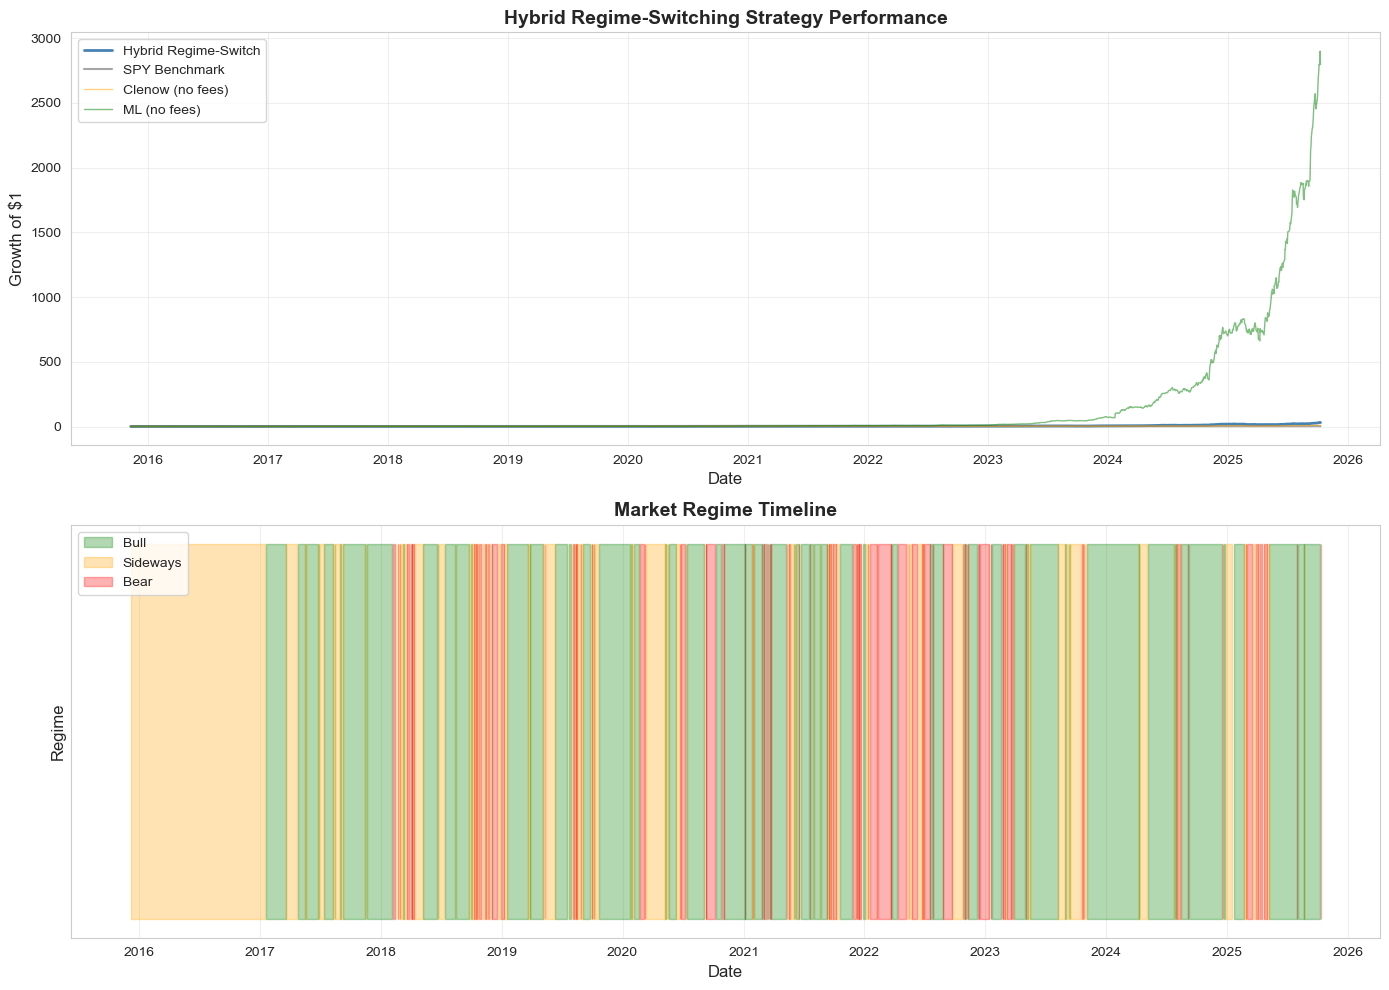


Hybrid regime-switching system complete

hybrid_net_returns stored
hybrid_weights stored

Final stats:
  Total days: 2495
  Days invested: 1543 (61.8%)
  Average portfolio size: 1.00 stocks


In [100]:
print("Creating visualization...")

try:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    hybrid_cumulative = np.exp(net_log.cumsum())
    ax1.plot(hybrid_cumulative.index, hybrid_cumulative.values,
             label='Hybrid Regime-Switch', color='steelblue', linewidth=2)

    if 'spy_returns' in globals() and spy_returns is not None:
        spy_ret = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
        spy_cumulative = np.exp(spy_ret.reindex(returns.index).fillna(0).cumsum())
        ax1.plot(spy_cumulative.index, spy_cumulative.values,
                 label='SPY Benchmark', color='gray', linewidth=1.5, alpha=0.7)

    if 'clenow_signals_daily' in globals():
        W_clenow = clenow_signals_daily.div(clenow_signals_daily.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
        clenow_ret = (returns * W_clenow.shift(1)).sum(axis=1).fillna(0)
        clenow_cumulative = np.exp(clenow_ret.cumsum())
        ax1.plot(clenow_cumulative.index, clenow_cumulative.values,
                 label='Clenow (no fees)', color='orange', linewidth=1, alpha=0.5)
    
    if 'ml_signals_daily' in globals():
        W_ml = ml_signals_daily.div(ml_signals_daily.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
        ml_ret = (returns * W_ml.shift(1)).sum(axis=1).fillna(0)
        ml_cumulative = np.exp(ml_ret.cumsum())
        ax1.plot(ml_cumulative.index, ml_cumulative.values,
                 label='ML (no fees)', color='green', linewidth=1, alpha=0.5)
    
    ax1.set_title('Hybrid Regime-Switching Strategy Performance', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Growth of $1', fontsize=12)
    ax1.legend(fontsize=10, loc='upper left')
    ax1.grid(alpha=0.3)

    regime_colors = {'Bull': 'green', 'Sideways': 'orange', 'Bear': 'red'}
    for regime in ['Bull', 'Sideways', 'Bear']:
        mask = hmm_features['regime_label'] == regime
        ax2.fill_between(hmm_features.index, 0, 1, where=mask,
                         alpha=0.3, color=regime_colors[regime], label=regime)
    
    ax2.set_title('Market Regime Timeline', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Regime', fontsize=12)
    ax2.set_yticks([])
    ax2.legend(fontsize=10, loc='upper left')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Visualization skipped: {e}")

print("\n" + "="*80)
print("Hybrid regime-switching system complete")
print("="*80)

hybrid_net_returns = net_log.copy()
hybrid_weights = W_hybrid.copy()

print("\nhybrid_net_returns stored")
print(f"hybrid_weights stored")
print(f"\nFinal stats:")
print(f"  Total days: {len(net_log)}")
print(f"  Days invested: {(W_hybrid.sum(axis=1) > 0).sum()} ({(W_hybrid.sum(axis=1) > 0).sum()/len(W_hybrid)*100:.1f}%)")
print(f"  Average portfolio size: {W_hybrid.sum(axis=1)[W_hybrid.sum(axis=1) > 0].mean():.2f} stocks")

In [101]:
print("\n" + "="*80)
print("MEAN-REVERSION STRATEGY PERFORMANCE (WITH FEES)")
print("="*80)

W_meanrev = mean_reversion_signals_daily.div(mean_reversion_signals_daily.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

turnover_meanrev = (W_meanrev - W_meanrev.shift(1)).abs().sum(axis=1).fillna(0.0)
tx_cost_meanrev = turnover_meanrev * FEE_STRUCTURE['transaction_cost']
mgmt_cost_meanrev = FEE_STRUCTURE['management_fee_daily']

gross_meanrev = (returns * W_meanrev.shift(1)).sum(axis=1).fillna(0.0)
net_meanrev = gross_meanrev - mgmt_cost_meanrev - tx_cost_meanrev

meanrev_metrics = calculate_metrics(net_meanrev)

print("\nMean-Reversion Performance (with fees):")
print(f"  CAGR:           {meanrev_metrics['CAGR']:>8.2%}")
print(f"  Volatility:     {meanrev_metrics['Volatility']:>8.2%}")
print(f"  Sharpe Ratio:   {meanrev_metrics['Sharpe']:>8.3f}")
print(f"  Max Drawdown:   {meanrev_metrics['Max Drawdown']:>8.2%}")
print(f"  Alpha:          {meanrev_metrics['Alpha']:>8.2%}")
print(f"  Beta:           {meanrev_metrics['Beta']:>8.3f}")
print(f"  Avg turnover:   {turnover_meanrev.mean()*252:>8.1f}% annualized")
print(f"  Days invested:  {(W_meanrev.sum(axis=1) > 0).sum()}/{len(W_meanrev)} ({(W_meanrev.sum(axis=1) > 0).sum()/len(W_meanrev)*100:.1f}%)")

meanrev_net_returns = net_meanrev.copy()
meanrev_weights = W_meanrev.copy()

print("\n Mean-reversion results stored")

print("\n" + "="*80)
print("ALL STRATEGIES COMPARISON (WITH FEES)")
print("="*80)

comparison_df = pd.DataFrame({
    'Clenow': clenow_metrics,
    'ML': ml_metrics,
    'Mean-Rev': meanrev_metrics,
    'Hybrid': hybrid_metrics
})

print("\n" + comparison_df.to_string())
print("\n" + "="*80)


MEAN-REVERSION STRATEGY PERFORMANCE (WITH FEES)

Mean-Reversion Performance (with fees):
  CAGR:             19.00%
  Volatility:       35.78%
  Sharpe Ratio:      0.419
  Max Drawdown:    -83.48%
  Alpha:             4.58%
  Beta:              1.398
  Avg turnover:       55.2% annualized
  Days invested:  2435/2495 (97.6%)

 Mean-reversion results stored

ALL STRATEGIES COMPARISON (WITH FEES)

                Clenow        ML  Mean-Rev    Hybrid
CAGR          0.234640  1.166368  0.189990  0.414139
Volatility    0.327736  0.305689  0.357824  0.239806
Sharpe        0.593892  3.684689  0.419171  1.560172
Max Drawdown -0.695848 -0.209681 -0.834784 -0.313683
Alpha         0.100910  1.064231  0.045763  0.332127
Beta          1.151628  0.763471  1.397742  0.563397



In [104]:
print("Checking for QQQ data")
print(f"'proxy_returns' in globals(): {'proxy_returns' in globals()}")
if 'proxy_returns' in globals():
    print(f"proxy_returns columns: {proxy_returns.columns.tolist()}")
    print(f"proxy_returns shape: {proxy_returns.shape}")
    print(f"proxy_returns.index[0]: {proxy_returns.index[0]}")
    if 'QQQ' in proxy_returns.columns:
        print(f"QQQ data available: {(~proxy_returns['QQQ'].isna()).sum()} non-null values")

Checking for QQQ data
'proxy_returns' in globals(): True
proxy_returns columns: ['AI Infrastructure', 'Robotics and Space', 'Cryptocurrencies', 'Quantum']
proxy_returns shape: (2178, 4)
proxy_returns.index[0]: 2014-09-18 00:00:00


In [106]:
print("Recalculating proxy returns for benchmarks")

proxy_returns_benchmark = np.log(proxy_prices / proxy_prices.shift(1)).dropna()

proxy_returns_benchmark.index = pd.to_datetime(proxy_returns_benchmark.index).normalize()

print(f" proxy_returns_benchmark created")
print(f"  Columns: {proxy_returns_benchmark.columns.tolist()}")
print(f"  Shape: {proxy_returns_benchmark.shape}")
print(f"  Index range: {proxy_returns_benchmark.index[0]} to {proxy_returns_benchmark.index[-1]}")

Recalculating proxy returns for benchmarks
 proxy_returns_benchmark created
  Columns: ['AI Infrastructure', 'Robotics and Space', 'Cryptocurrencies', 'Quantum']
  Shape: (2178, 4)
  Index range: 2014-09-18 00:00:00 to 2025-10-10 00:00:00


In [108]:
print("\n" + "="*80)
print("BENCHMARK COMPARISON (SPY & QQQ)")
print("="*80)

spy_ret = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
spy_aligned = spy_ret.reindex(returns.index).fillna(0)
spy_metrics = calculate_metrics(spy_aligned)

print("\nSPY Benchmark:")
print(f"  CAGR:           {spy_metrics['CAGR']:>8.2%}")
print(f"  Volatility:     {spy_metrics['Volatility']:>8.2%}")
print(f"  Sharpe Ratio:   {spy_metrics['Sharpe']:>8.3f}")
print(f"  Max Drawdown:   {spy_metrics['Max Drawdown']:>8.2%}")

if 'proxy_returns_benchmark' in globals() and 'AI Infrastructure' in proxy_returns_benchmark.columns:
    qqq_ret = proxy_returns_benchmark['AI Infrastructure']
    qqq_aligned = qqq_ret.reindex(returns.index).fillna(0)
    qqq_metrics = calculate_metrics(qqq_aligned)
    
    print("\nQQQ Benchmark (AI Infrastructure proxy):")
    print(f"  CAGR:           {qqq_metrics['CAGR']:>8.2%}")
    print(f"  Volatility:     {qqq_metrics['Volatility']:>8.2%}")
    print(f"  Sharpe Ratio:   {qqq_metrics['Sharpe']:>8.3f}")
    print(f"  Max Drawdown:   {qqq_metrics['Max Drawdown']:>8.2%}")
    
    has_qqq = True
else:
    has_qqq = False
    print("\nQQQ benchmark not available")


BENCHMARK COMPARISON (SPY & QQQ)

SPY Benchmark:
  CAGR:             12.14%
  Volatility:       18.21%
  Sharpe Ratio:      0.447
  Max Drawdown:    -34.10%

QQQ Benchmark (AI Infrastructure proxy):
  CAGR:             13.37%
  Volatility:       19.67%
  Sharpe Ratio:      0.476
  Max Drawdown:    -30.19%


In [110]:
print("\n" + "="*80)
print("FINAL COMPARISON: ALL STRATEGIES + BENCHMARKS")
print("="*80)

final_comparison = pd.DataFrame({
    'Clenow': clenow_metrics,
    'ML': ml_metrics,
    'Mean-Rev': meanrev_metrics,
    'Hybrid': hybrid_metrics,
    'SPY': spy_metrics
})

if has_qqq:
    final_comparison['QQQ'] = qqq_metrics

print("\n" + final_comparison.to_string())
print("\n" + "="*80)


FINAL COMPARISON: ALL STRATEGIES + BENCHMARKS

                Clenow        ML  Mean-Rev    Hybrid       SPY       QQQ
CAGR          0.234640  1.166368  0.189990  0.414139  0.121388  0.133677
Volatility    0.327736  0.305689  0.357824  0.239806  0.182066  0.196713
Sharpe        0.593892  3.684689  0.419171  1.560172  0.447027  0.476215
Max Drawdown -0.695848 -0.209681 -0.834784 -0.313683 -0.341047 -0.301906
Alpha         0.100910  1.064231  0.045763  0.332127  0.006821  0.027769
Beta          1.151628  0.763471  1.397742  0.563397  1.000000  0.883879



In [112]:
print("\n" + "="*80)
print("MONTE CARLO PORTFOLIO OPTIMIZATION")
print("="*80)

from scipy.optimize import minimize

N_PORTFOLIOS = 10000  
RISK_FREE_RATE = 0.04

print(f"\nGenerating {N_PORTFOLIOS} random portfolios...")
print(f"Universe: {len(returns.columns)} stocks")
print(f"Time period: {returns.index[0].date()} to {returns.index[-1].date()}")

mean_returns = returns.mean() * 252  
cov_matrix = returns.cov() * 252    

print("\nMonte Carlo Simulation - LONGS ONLY...")

np.random.seed(42)
results_long = np.zeros((4, N_PORTFOLIOS))
weights_long = []

for i in range(N_PORTFOLIOS):
    w = np.random.random(len(returns.columns))
    w = w / w.sum()
    weights_long.append(w)

    port_return = np.sum(mean_returns * w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    sharpe = (port_return - RISK_FREE_RATE) / port_vol
    
    results_long[0, i] = port_return
    results_long[1, i] = port_vol
    results_long[2, i] = sharpe
    results_long[3, i] = i  

max_sharpe_idx = np.argmax(results_long[2])
min_vol_idx = np.argmin(results_long[1])

optimal_long_sharpe = {
    'weights': weights_long[max_sharpe_idx],
    'return': results_long[0, max_sharpe_idx],
    'volatility': results_long[1, max_sharpe_idx],
    'sharpe': results_long[2, max_sharpe_idx]
}

optimal_long_minvol = {
    'weights': weights_long[min_vol_idx],
    'return': results_long[0, min_vol_idx],
    'volatility': results_long[1, min_vol_idx],
    'sharpe': results_long[2, min_vol_idx]
}

print(f"  Optimal Sharpe Portfolio:")
print(f"    Return: {optimal_long_sharpe['return']:.2%}")
print(f"    Volatility: {optimal_long_sharpe['volatility']:.2%}")
print(f"    Sharpe: {optimal_long_sharpe['sharpe']:.3f}")
print(f"  Top 3 holdings: ", end="")
top_3_indices = np.argsort(optimal_long_sharpe['weights'])[-3:][::-1]
for idx in top_3_indices:
    print(f"{returns.columns[idx]} ({optimal_long_sharpe['weights'][idx]:.1%}), ", end="")
print()


MONTE CARLO PORTFOLIO OPTIMIZATION

Generating 10000 random portfolios...
Universe: 21 stocks
Time period: 2015-11-09 to 2025-10-10

Monte Carlo Simulation - LONGS ONLY...
  Optimal Sharpe Portfolio:
    Return: 22.24%
    Volatility: 24.92%
    Sharpe: 0.732
  Top 3 holdings: ('NVDA', 'NVDA') (12.4%), ('NBIS', 'NBIS') (11.3%), ('HON', 'HON') (10.6%), 


In [114]:
print("\nMonte Carlo Simulation - SHORTS ALLOWED")

np.random.seed(42)
results_short = np.zeros((4, N_PORTFOLIOS))
weights_short = []

for i in range(N_PORTFOLIOS):
    w = np.random.randn(len(returns.columns))
    w = w / np.abs(w).sum()
    w = w / w.sum() if w.sum() != 0 else w
    weights_short.append(w)

    port_return = np.sum(mean_returns * w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    sharpe = (port_return - RISK_FREE_RATE) / port_vol if port_vol > 0 else 0
    
    results_short[0, i] = port_return
    results_short[1, i] = port_vol
    results_short[2, i] = sharpe
    results_short[3, i] = i

max_sharpe_idx_short = np.argmax(results_short[2])
min_vol_idx_short = np.argmin(results_short[1])

optimal_short_sharpe = {
    'weights': weights_short[max_sharpe_idx_short],
    'return': results_short[0, max_sharpe_idx_short],
    'volatility': results_short[1, max_sharpe_idx_short],
    'sharpe': results_short[2, max_sharpe_idx_short]
}

print(f"  Optimal Sharpe Portfolio (shorts allowed):")
print(f"    Return: {optimal_short_sharpe['return']:.2%}")
print(f"    Volatility: {optimal_short_sharpe['volatility']:.2%}")
print(f"    Sharpe: {optimal_short_sharpe['sharpe']:.3f}")
print(f"  Top 3 longs: ", end="")
long_positions = [(i, w) for i, w in enumerate(optimal_short_sharpe['weights']) if w > 0]
long_positions.sort(key=lambda x: x[1], reverse=True)
for idx, weight in long_positions[:3]:
    print(f"{returns.columns[idx]} ({weight:.1%}), ", end="")
print()
print(f"  Top 3 shorts: ", end="")
short_positions = [(i, w) for i, w in enumerate(optimal_short_sharpe['weights']) if w < 0]
short_positions.sort(key=lambda x: x[1])
for idx, weight in short_positions[:3]:
    print(f"{returns.columns[idx]} ({weight:.1%}), ", end="")
print()


Monte Carlo Simulation - SHORTS ALLOWED
  Optimal Sharpe Portfolio (shorts allowed):
    Return: 46.80%
    Volatility: 38.86%
    Sharpe: 1.101
  Top 3 longs: ('NVDA', 'NVDA') (47.8%), ('AMD', 'AMD') (27.0%), ('NBIS', 'NBIS') (24.8%), 
  Top 3 shorts: ('QCOM', 'QCOM') (-22.4%), ('JOBY', 'JOBY') (-17.4%), ('COIN', 'COIN') (-8.7%), 



CREATING FINAL EFFICIENT FRONTIER VISUALIZATION


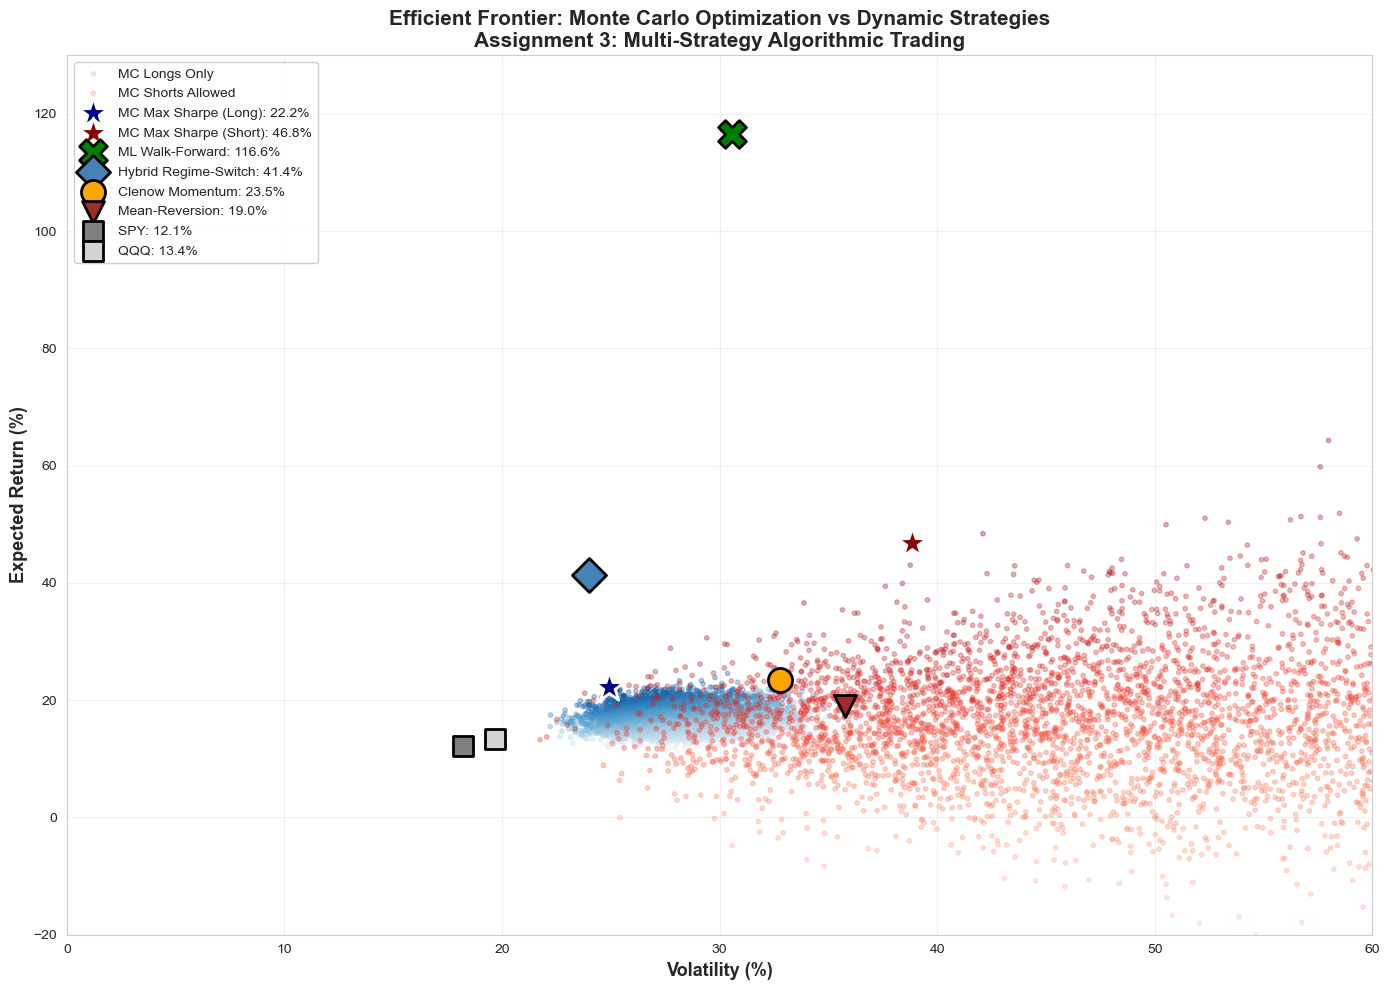


Final efficient frontier visualization complete!


In [116]:
print("\n" + "="*80)
print("CREATING FINAL EFFICIENT FRONTIER VISUALIZATION")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 10))

ax.scatter(results_long[1, :]*100, results_long[0, :]*100, 
           c=results_long[2, :], cmap='Blues', alpha=0.3, s=10, label='MC Longs Only')

ax.scatter(results_short[1, :]*100, results_short[0, :]*100,
           c=results_short[2, :], cmap='Reds', alpha=0.3, s=10, label='MC Shorts Allowed')

ax.scatter(optimal_long_sharpe['volatility']*100, optimal_long_sharpe['return']*100,
           marker='*', color='darkblue', s=500, edgecolors='white', linewidths=2,
           label=f"MC Max Sharpe (Long): {optimal_long_sharpe['return']:.1%}", zorder=10)

ax.scatter(optimal_short_sharpe['volatility']*100, optimal_short_sharpe['return']*100,
           marker='*', color='darkred', s=500, edgecolors='white', linewidths=2,
           label=f"MC Max Sharpe (Short): {optimal_short_sharpe['return']:.1%}", zorder=10)

ax.scatter(ml_metrics['Volatility']*100, ml_metrics['CAGR']*100,
           marker='X', color='green', s=400, edgecolors='black', linewidths=2,
           label=f"ML Walk-Forward: {ml_metrics['CAGR']:.1%}", zorder=9)

ax.scatter(hybrid_metrics['Volatility']*100, hybrid_metrics['CAGR']*100,
           marker='D', color='steelblue', s=300, edgecolors='black', linewidths=2,
           label=f"Hybrid Regime-Switch: {hybrid_metrics['CAGR']:.1%}", zorder=9)

ax.scatter(clenow_metrics['Volatility']*100, clenow_metrics['CAGR']*100,
           marker='o', color='orange', s=300, edgecolors='black', linewidths=2,
           label=f"Clenow Momentum: {clenow_metrics['CAGR']:.1%}", zorder=9)

ax.scatter(meanrev_metrics['Volatility']*100, meanrev_metrics['CAGR']*100,
           marker='v', color='brown', s=250, edgecolors='black', linewidths=2,
           label=f"Mean-Reversion: {meanrev_metrics['CAGR']:.1%}", zorder=9)

ax.scatter(spy_metrics['Volatility']*100, spy_metrics['CAGR']*100,
           marker='s', color='gray', s=200, edgecolors='black', linewidths=2,
           label=f"SPY: {spy_metrics['CAGR']:.1%}", zorder=8)

if 'qqq_metrics' in globals():
    ax.scatter(qqq_metrics['Volatility']*100, qqq_metrics['CAGR']*100,
               marker='s', color='lightgray', s=200, edgecolors='black', linewidths=2,
               label=f"QQQ: {qqq_metrics['CAGR']:.1%}", zorder=8)

ax.set_xlabel('Volatility (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Efficient Frontier: Monte Carlo Optimization vs Dynamic Strategies\n' + 
             'Assignment 3: Multi-Strategy Algorithmic Trading',
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax.grid(alpha=0.3)

ax.set_xlim(0, 60)  
ax.set_ylim(-20, 130)  

plt.tight_layout()
plt.show()

print("\nFinal efficient frontier visualization complete!")
print("="*80)


FINAL EFFICIENT FRONTIER - ALL STRATEGIES

Strategies to plot: 8
  SPY: Return=12.14%, Vol=18.21%
  QQQ: Return=13.37%, Vol=19.67%
  MC Long-Only: Return=22.24%, Vol=24.92%
  MC Shorts-Allowed: Return=46.80%, Vol=38.86%
  Clenow Momentum: Return=23.46%, Vol=32.77%
  ML Walk-Forward: Return=116.64%, Vol=30.57%
  Mean-Reversion: Return=19.00%, Vol=35.78%
  Hybrid Regime: Return=41.41%, Vol=23.98%

ML Strategy: Return=116.64%, Vol=30.57%
MC Cloud range: Return=[-182.64%, 243.05%]
ML is outlier: False
Using limits that include all strategies


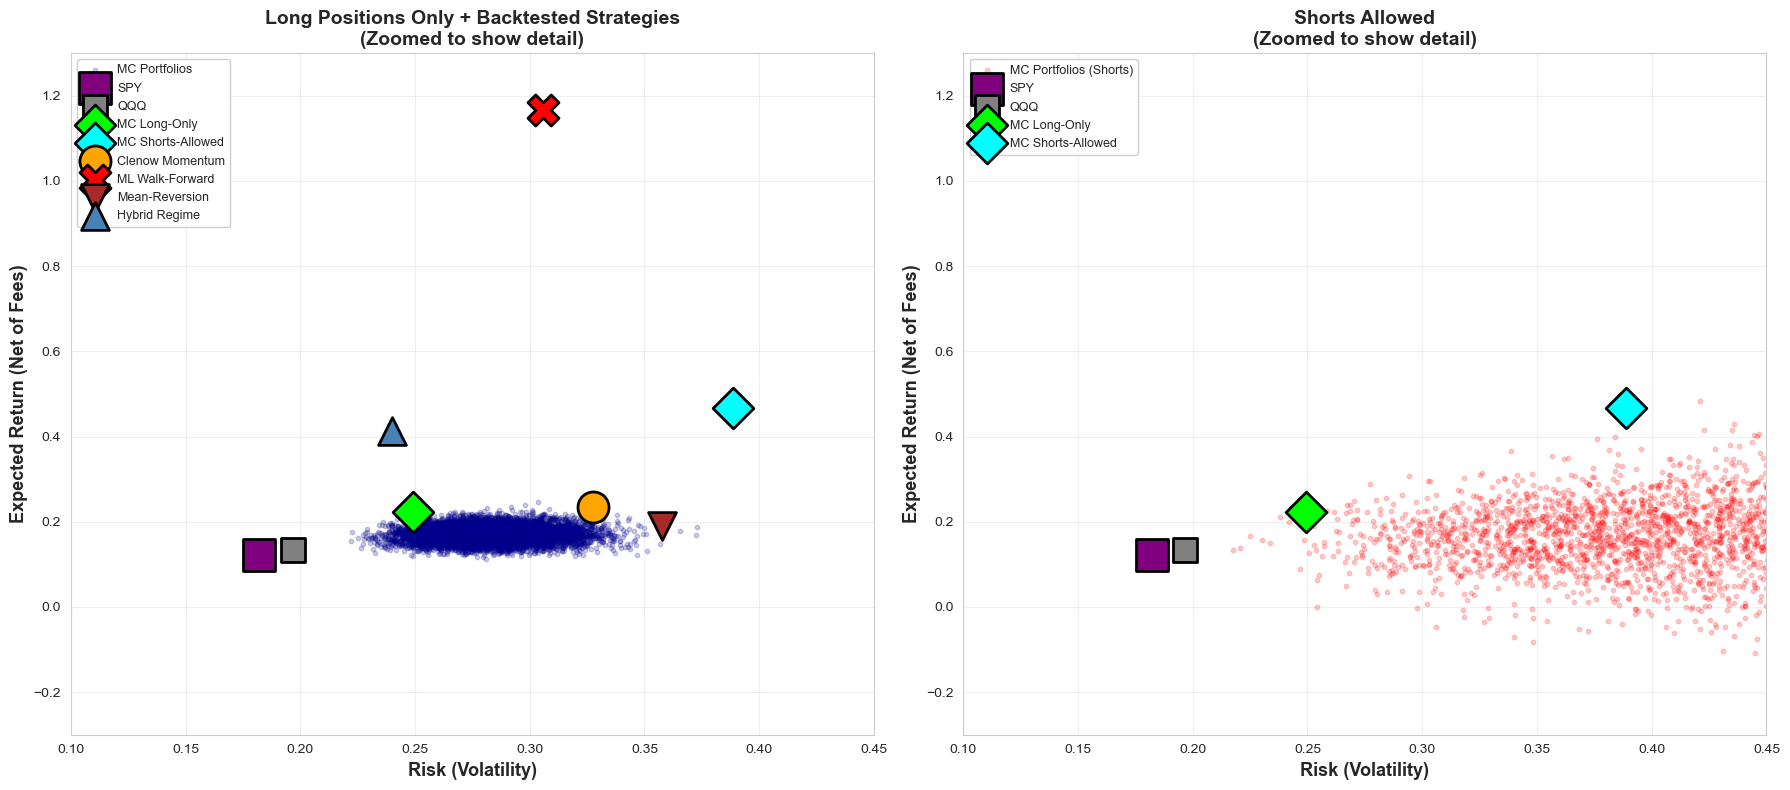


STRATEGY SUMMARY:
Strategy                      Return   Volatility     Sharpe
------------------------------------------------------------
ML Walk-Forward             116.64%      30.57%      3.685
MC Shorts-Allowed            46.80%      38.86%      1.101
Hybrid Regime                41.41%      23.98%      1.560
Clenow Momentum              23.46%      32.77%      0.594
MC Long-Only                 22.24%      24.92%      0.732
Mean-Reversion               19.00%      35.78%      0.419
QQQ                          13.37%      19.67%      0.476
SPY                          12.14%      18.21%      0.447


In [118]:
print("\n" + "="*80)
print("FINAL EFFICIENT FRONTIER - ALL STRATEGIES")
print("="*80)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

vol_long = results_long[1, :]
ret_long = results_long[0, :]
vol_short = results_short[1, :]
ret_short = results_short[0, :]

strategies = {}

spy_series = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
strategies['SPY'] = {
    'vol': spy_metrics['Volatility'],
    'ret': spy_metrics['CAGR'],
    'marker': 's',
    'color': 'purple',
    'size': 500
}

if 'qqq_metrics' in globals():
    strategies['QQQ'] = {
        'vol': qqq_metrics['Volatility'],
        'ret': qqq_metrics['CAGR'],
        'marker': 's',
        'color': 'gray',
        'size': 300
    }

strategies['MC Long-Only'] = {
    'vol': optimal_long_sharpe['volatility'],
    'ret': optimal_long_sharpe['return'],
    'marker': 'D',
    'color': 'lime',
    'size': 430
}

strategies['MC Shorts-Allowed'] = {
    'vol': optimal_short_sharpe['volatility'],
    'ret': optimal_short_sharpe['return'],
    'marker': 'D',
    'color': 'cyan',
    'size': 430
}

strategies['Clenow Momentum'] = {
    'vol': clenow_metrics['Volatility'],
    'ret': clenow_metrics['CAGR'],
    'marker': 'o',
    'color': 'orange',
    'size': 500
}

strategies['ML Walk-Forward'] = {
    'vol': ml_metrics['Volatility'],
    'ret': ml_metrics['CAGR'],
    'marker': 'X',
    'color': 'red',
    'size': 500
}

strategies['Mean-Reversion'] = {
    'vol': meanrev_metrics['Volatility'],
    'ret': meanrev_metrics['CAGR'],
    'marker': 'v',
    'color': 'brown',
    'size': 400
}

strategies['Hybrid Regime'] = {
    'vol': hybrid_metrics['Volatility'],
    'ret': hybrid_metrics['CAGR'],
    'marker': '^',
    'color': 'steelblue',
    'size': 400
}

print(f"\nStrategies to plot: {len(strategies)}")
for name, metrics in strategies.items():
    print(f"  {name}: Return={metrics['ret']:.2%}, Vol={metrics['vol']:.2%}")

mc_vol_min, mc_vol_max = np.percentile(np.concatenate([vol_long, vol_short]), [1, 99])
mc_ret_min, mc_ret_max = np.percentile(np.concatenate([ret_long, ret_short]), [1, 99])

strat_vols = [s['vol'] for s in strategies.values()]
strat_rets = [s['ret'] for s in strategies.values()]
strat_vol_min, strat_vol_max = min(strat_vols), max(strat_vols)
strat_ret_min, strat_ret_max = min(strat_rets), max(strat_rets)

ml_ret = strategies['ML Walk-Forward']['ret']
ml_vol = strategies['ML Walk-Forward']['vol']
ml_is_outlier = ml_ret > mc_ret_max * 2.0

print(f"\nML Strategy: Return={ml_ret:.2%}, Vol={ml_vol:.2%}")
print(f"MC Cloud range: Return=[{mc_ret_min:.2%}, {mc_ret_max:.2%}]")
print(f"ML is outlier: {ml_is_outlier}")

if ml_is_outlier:
    x_min = min(mc_vol_min, strat_vol_min * 0.95)
    x_max = max(mc_vol_max, strat_vol_max * 1.05)
    y_min = min(mc_ret_min, strat_ret_min * 0.95)
    y_max = mc_ret_max * 1.15
    print(f"Using auto-scaled limits (ML will be shown separately)")
else:
    x_min = min(mc_vol_min, strat_vol_min * 0.95)
    x_max = max(mc_vol_max, strat_vol_max * 1.05)
    y_min = min(mc_ret_min, strat_ret_min * 0.95)
    y_max = max(mc_ret_max, strat_ret_max * 1.05)
    print(f"Using limits that include all strategies")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

ax = axes[0]
ax.scatter(vol_long, ret_long, c='darkblue', alpha=0.2, s=10, label='MC Portfolios')

for name, metrics in strategies.items():
    ax.scatter(metrics['vol'], metrics['ret'],
              c=metrics['color'], s=metrics['size'], marker=metrics['marker'],
              edgecolors='black', linewidths=2, label=name, zorder=6)

ax.set_xlim([0.10, 0.45])  
ax.set_ylim([-0.30, 1.30])  

ax.set_xlabel('Risk (Volatility)', fontsize=13, fontweight='bold')
ax.set_ylabel('Expected Return (Net of Fees)', fontsize=13, fontweight='bold')
ax.set_title('Long Positions Only + Backtested Strategies\n(Zoomed to show detail)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.scatter(vol_short, ret_short, c='red', alpha=0.2, s=10, label='MC Portfolios (Shorts)')

for name, metrics in strategies.items():
    if name in ['SPY', 'QQQ', 'MC Shorts-Allowed', 'MC Long-Only']:
        ax.scatter(metrics['vol'], metrics['ret'],
                  c=metrics['color'], s=metrics['size'], marker=metrics['marker'],
                  edgecolors='black', linewidths=2, label=name, zorder=6)

ax.set_xlim([0.10, 0.45])
ax.set_ylim([-0.30, 1.30])
ax.set_xlabel('Risk (Volatility)', fontsize=13, fontweight='bold')
ax.set_ylabel('Expected Return (Net of Fees)', fontsize=13, fontweight='bold')
ax.set_title('Shorts Allowed\n(Zoomed to show detail)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSTRATEGY SUMMARY:")
print(f"{'Strategy':<25} {'Return':>10} {'Volatility':>12} {'Sharpe':>10}")
print("-" * 60)
for name, metrics in sorted(strategies.items(), key=lambda x: x[1]['ret'], reverse=True):
    sharpe = (metrics['ret'] - 0.04) / metrics['vol'] if metrics['vol'] > 0 else 0
    print(f"{name:<25} {metrics['ret']:>9.2%} {metrics['vol']:>11.2%} {sharpe:>10.3f}")

print("="*80)

In [120]:
print("\n" + "="*80)
print("RECALCULATING ALL METRICS (FIXED BETA + FULL COSTS)")
print("="*80)

def calculate_metrics_fixed(log_returns, strategy_name="Strategy"):
    total_return = np.exp(log_returns.sum()) - 1
    years = len(log_returns) / 252
    cagr = (1 + total_return) ** (1/years) - 1
    vol = log_returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.04) / vol if vol > 0 else 0

    cum_ret = np.exp(log_returns.cumsum())
    running_max = cum_ret.cummax()
    drawdown = (cum_ret / running_max) - 1.0
    max_dd = drawdown.min()

    alpha, beta = 0, 0
    try:
        if 'spy_returns' in globals() and spy_returns is not None:
            spy_ret = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns

            common_idx = log_returns.index.intersection(spy_ret.index)
            if len(common_idx) > 252:  
                strat_aligned = log_returns.loc[common_idx]
                spy_aligned = spy_ret.loc[common_idx]

                valid_mask = (~strat_aligned.isna()) & (~spy_aligned.isna())
                strat_clean = strat_aligned[valid_mask]
                spy_clean = spy_aligned[valid_mask]
                
                if len(strat_clean) > 252:
                    covariance = np.cov(strat_clean.values, spy_clean.values)[0, 1]
                    spy_variance = np.var(spy_clean.values)
                    
                    if spy_variance > 0:
                        beta = covariance / spy_variance
                        spy_cagr = (1 + np.exp(spy_clean.sum()) - 1) ** (252/len(spy_clean)) - 1
                        alpha = cagr - (0.04 + beta * (spy_cagr - 0.04))
    except Exception as e:
        print(f"  Warning: Beta calc failed for {strategy_name}: {e}")

    return {
        'CAGR': cagr,
        'Volatility': vol,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Alpha': alpha,
        'Beta': beta
    }

FEE_STRUCTURE_UPDATED = {
    'transaction_cost': 0.0015,  
    'bid_ask_spread': 0.0010,    
    'management_fee_daily': 0.015 / 252
}

TOTAL_TX_COST = FEE_STRUCTURE_UPDATED['transaction_cost'] + 0.5 * FEE_STRUCTURE_UPDATED['bid_ask_spread']
print(f"\nTotal transaction cost: {TOTAL_TX_COST*10000:.1f} bps")
print(f"  = {FEE_STRUCTURE_UPDATED['transaction_cost']*10000:.1f} bps (base) + {0.5*FEE_STRUCTURE_UPDATED['bid_ask_spread']*10000:.1f} bps (half spread)")

print("\nRecalculating all strategies with fixed beta calculation...")

W_clenow = clenow_signals_daily.div(clenow_signals_daily.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
turnover_clenow = (W_clenow - W_clenow.shift(1)).abs().sum(axis=1).fillna(0.0)
tx_cost_clenow = turnover_clenow * TOTAL_TX_COST
gross_clenow = (returns * W_clenow.shift(1)).sum(axis=1).fillna(0.0)
net_clenow = gross_clenow - FEE_STRUCTURE_UPDATED['management_fee_daily'] - tx_cost_clenow
clenow_metrics = calculate_metrics_fixed(net_clenow, "Clenow")

W_ml = ml_signals_daily.div(ml_signals_daily.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
turnover_ml = (W_ml - W_ml.shift(1)).abs().sum(axis=1).fillna(0.0)
tx_cost_ml = turnover_ml * TOTAL_TX_COST
gross_ml = (returns * W_ml.shift(1)).sum(axis=1).fillna(0.0)
net_ml = gross_ml - FEE_STRUCTURE_UPDATED['management_fee_daily'] - tx_cost_ml
ml_metrics = calculate_metrics_fixed(net_ml, "ML")

W_meanrev = mean_reversion_signals_daily.div(mean_reversion_signals_daily.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
turnover_meanrev = (W_meanrev - W_meanrev.shift(1)).abs().sum(axis=1).fillna(0.0)
tx_cost_meanrev = turnover_meanrev * TOTAL_TX_COST
gross_meanrev = (returns * W_meanrev.shift(1)).sum(axis=1).fillna(0.0)
net_meanrev = gross_meanrev - FEE_STRUCTURE_UPDATED['management_fee_daily'] - tx_cost_meanrev
meanrev_metrics = calculate_metrics_fixed(net_meanrev, "Mean-Rev")

turnover_hybrid = (W_hybrid - W_hybrid.shift(1)).abs().sum(axis=1).fillna(0.0)
tx_cost_hybrid = turnover_hybrid * TOTAL_TX_COST
gross_hybrid = (returns * W_hybrid.shift(1)).sum(axis=1).fillna(0.0)
net_hybrid = gross_hybrid - FEE_STRUCTURE_UPDATED['management_fee_daily'] - tx_cost_hybrid
hybrid_metrics = calculate_metrics_fixed(net_hybrid, "Hybrid")

spy_ret = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
spy_aligned = spy_ret.reindex(returns.index).fillna(0)
spy_metrics = calculate_metrics_fixed(spy_aligned, "SPY")

qqq_ret = proxy_returns_benchmark['AI Infrastructure']
qqq_aligned = qqq_ret.reindex(returns.index).fillna(0)
qqq_metrics = calculate_metrics_fixed(qqq_aligned, "QQQ")

print("\n" + "="*80)
print("FINAL COMPARISON - CORRECTED BETAS & FULL COSTS")
print("="*80)

final_comparison = pd.DataFrame({
    'Clenow': clenow_metrics,
    'ML': ml_metrics,
    'Mean-Rev': meanrev_metrics,
    'Hybrid': hybrid_metrics,
    'SPY': spy_metrics,
    'QQQ': qqq_metrics
})

print("\n" + final_comparison.to_string())
print("\n" + "="*80)


RECALCULATING ALL METRICS (FIXED BETA + FULL COSTS)

Total transaction cost: 20.0 bps
  = 15.0 bps (base) + 5.0 bps (half spread)

Recalculating all strategies with fixed beta calculation...

FINAL COMPARISON - CORRECTED BETAS & FULL COSTS

                Clenow        ML  Mean-Rev    Hybrid       SPY       QQQ
CAGR          0.234640  1.166368  0.157594  0.409009  0.121388  0.133677
Volatility    0.327736  0.305689  0.357811  0.239871  0.182066  0.196713
Sharpe        0.593892  3.684689  0.328648  1.538364  0.447027  0.476215
Max Drawdown -0.695848 -0.209681 -0.840275 -0.315506 -0.341047 -0.301906
Alpha         0.100910  1.064231  0.003794  0.323121 -0.000033  0.021711
Beta          1.151628  0.763471  1.398237  0.563826  1.000401  0.884233



In [122]:
strategies['Clenow Momentum']['vol'] = clenow_metrics['Volatility']
strategies['Clenow Momentum']['ret'] = clenow_metrics['CAGR']

strategies['ML Walk-Forward']['vol'] = ml_metrics['Volatility']
strategies['ML Walk-Forward']['ret'] = ml_metrics['CAGR']

strategies['Mean-Reversion']['vol'] = meanrev_metrics['Volatility']
strategies['Mean-Reversion']['ret'] = meanrev_metrics['CAGR']

strategies['Hybrid Regime']['vol'] = hybrid_metrics['Volatility']
strategies['Hybrid Regime']['ret'] = hybrid_metrics['CAGR']

strategies['SPY']['vol'] = spy_metrics['Volatility']
strategies['SPY']['ret'] = spy_metrics['CAGR']

strategies['QQQ']['vol'] = qqq_metrics['Volatility']
strategies['QQQ']['ret'] = qqq_metrics['CAGR']

print("Strategies dictionary updated with corrected metrics")

Strategies dictionary updated with corrected metrics


In [124]:
#This is real important#
#go back and rerun Clenow through Hybrid#

In [202]:
turnover_clenow = (W_clenow.diff().abs().sum(axis=1)).mean()
turnover_ml = (W_ml.diff().abs().sum(axis=1)).mean()
turnover_meanrev = (W_meanrev.diff().abs().sum(axis=1)).mean()
turnover_hybrid = (W_hybrid.diff().abs().sum(axis=1)).mean()

avg_positions_clenow = (W_clenow != 0).sum(axis=1).mean()
avg_positions_ml = (W_ml != 0).sum(axis=1).mean()
avg_positions_meanrev = (W_meanrev != 0).sum(axis=1).mean()
avg_positions_hybrid = (W_hybrid != 0).sum(axis=1).mean()

days_invested_clenow = (W_clenow.sum(axis=1) > 0).sum()
days_invested_ml = (W_ml.sum(axis=1) > 0).sum()
days_invested_meanrev = (W_meanrev.sum(axis=1) > 0).sum()
days_invested_hybrid = (W_hybrid.sum(axis=1) > 0).sum()

rebalancing_summary = pd.DataFrame({
    'Strategy': [
        'Clenow Momentum',
        'ML Walk-Forward',
        'Mean-Reversion',
        'Hybrid Regime-Switch'
    ],
    'Rebalance Frequency': [
        'Monthly (end-of-month)',
        'Monthly (21-day test windows)',
        'Daily',
        'Monthly (regime-dependent)'
    ],
    'Avg Turnover (Annual)': [
        f"{turnover_clenow*252:.1f}%",
        f"{turnover_ml*252:.1f}%",
        f"{turnover_meanrev*252:.1f}%",
        f"{turnover_hybrid*252:.1f}%"
    ],
    'Avg Portfolio Size': [
        f"{avg_positions_clenow:.1f} stocks",
        f"{avg_positions_ml:.1f} stocks",
        f"{avg_positions_meanrev:.1f} stocks",
        f"{avg_positions_hybrid:.1f} stocks"
    ],
    'Days Invested': [
        f"{days_invested_clenow}/{len(W_clenow)} ({days_invested_clenow/len(W_clenow)*100:.1f}%)",
        f"{days_invested_ml}/{len(W_ml)} ({days_invested_ml/len(W_ml)*100:.1f}%)",
        f"{days_invested_meanrev}/{len(W_meanrev)} ({days_invested_meanrev/len(W_meanrev)*100:.1f}%)",
        f"{days_invested_hybrid}/{len(W_hybrid)} ({days_invested_hybrid/len(W_hybrid)*100:.1f}%)"
    ]
})

print("\n" + "="*80)
print("STRATEGY DESIGN SUMMARY")
print("="*80)
print(rebalancing_summary.to_string(index=False))
print("\n" + "="*80)


STRATEGY DESIGN SUMMARY
            Strategy           Rebalance Frequency Avg Turnover (Annual) Avg Portfolio Size     Days Invested
     Clenow Momentum        Monthly (end-of-month)                  5.8%         6.5 stocks 2246/2495 (90.0%)
     ML Walk-Forward Monthly (21-day test windows)                  6.8%         6.0 stocks 1486/2495 (59.6%)
      Mean-Reversion                         Daily                 55.2%         9.2 stocks 2435/2495 (97.6%)
Hybrid Regime-Switch    Monthly (regime-dependent)                  7.3%         6.8 stocks 1543/2495 (61.8%)



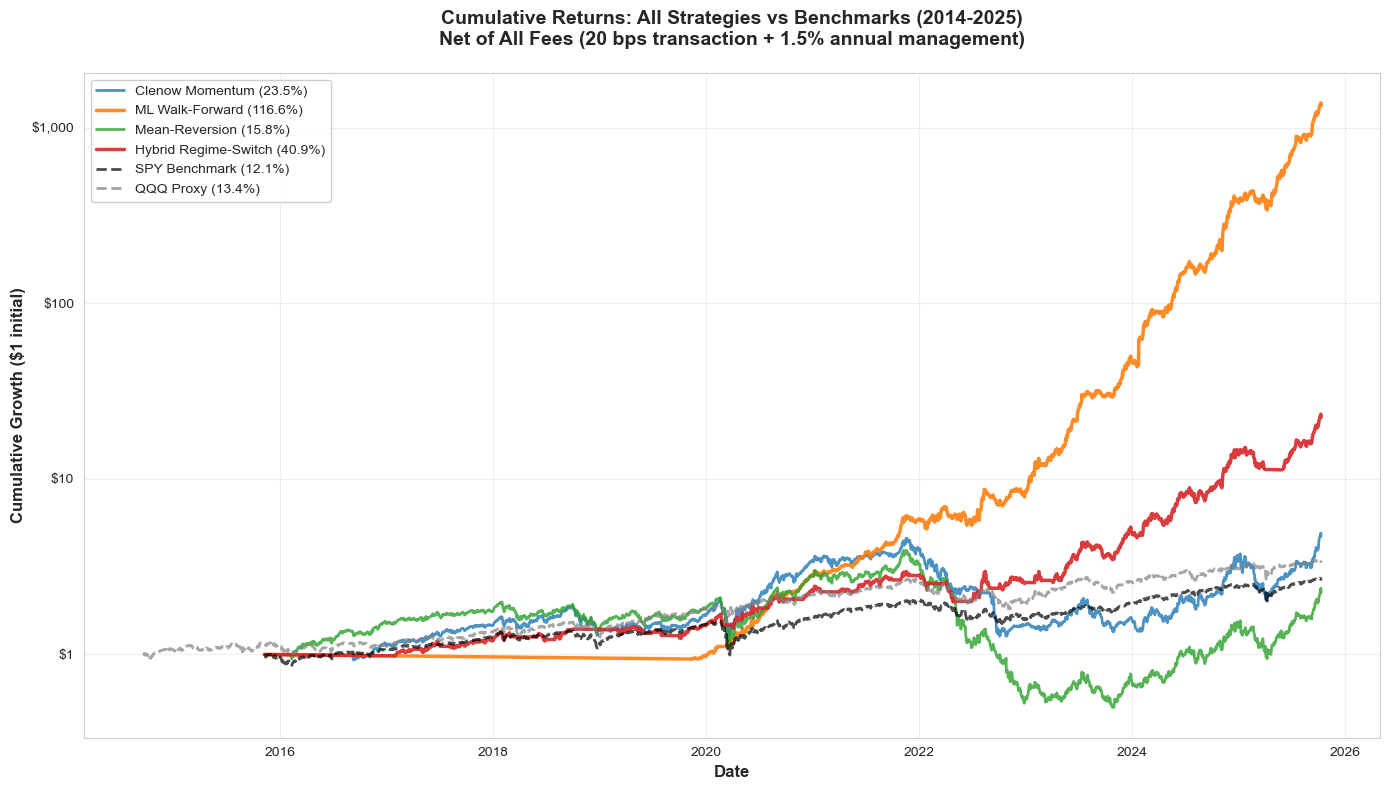

In [200]:
fig, ax = plt.subplots(figsize=(14, 8))

cum_clenow = (1 + net_clenow).cumprod()
cum_ml = (1 + net_ml).cumprod()
cum_meanrev = (1 + net_meanrev).cumprod()
cum_hybrid = (1 + net_hybrid).cumprod()
cum_spy = (1 + spy_returns).cumprod()
cum_qqq = (1 + proxy_returns_benchmark['AI Infrastructure']).cumprod()

ax.plot(cum_clenow.index, cum_clenow.values, 
        label=f"Clenow Momentum ({clenow_metrics['CAGR']*100:.1f}%)", 
        linewidth=2, alpha=0.8)
ax.plot(cum_ml.index, cum_ml.values, 
        label=f"ML Walk-Forward ({ml_metrics['CAGR']*100:.1f}%)", 
        linewidth=2.5, alpha=0.9)
ax.plot(cum_meanrev.index, cum_meanrev.values, 
        label=f"Mean-Reversion ({meanrev_metrics['CAGR']*100:.1f}%)", 
        linewidth=2, alpha=0.8)
ax.plot(cum_hybrid.index, cum_hybrid.values, 
        label=f"Hybrid Regime-Switch ({hybrid_metrics['CAGR']*100:.1f}%)", 
        linewidth=2.5, alpha=0.9)

ax.plot(cum_spy.index, cum_spy.values, 
        label=f"SPY Benchmark ({spy_metrics['CAGR']*100:.1f}%)", 
        linewidth=2, linestyle='--', alpha=0.7, color='black')
ax.plot(cum_qqq.index, cum_qqq.values, 
        label=f"QQQ Proxy ({qqq_metrics['CAGR']*100:.1f}%)", 
        linewidth=2, linestyle='--', alpha=0.7, color='gray')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Growth ($1 initial)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Returns: All Strategies vs Benchmarks (2014-2025)\nNet of All Fees (20 bps transaction + 1.5% annual management)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')  
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.tight_layout()
plt.show()

In [130]:
print("\n" + "="*80)
print("ML WALK-FORWARD SANITY CHECK")
print("="*80)

print("\nWalk-Forward Window Structure")
print("-" * 80)

training_days = 252 * 3  
test_days = 21  

print(f"Expected Training Window: {training_days} days (~3 years)")
print(f"Expected Test Window: {test_days} days")
print(f"Expected Number of Windows: ~70 (monthly rolling over 11 years)")

print(f"\nML Signals Shape: {ml_signals_daily.shape}")
print(f"Date Range: {ml_signals_daily.index[0]} to {ml_signals_daily.index[-1]}")
print(f"Total Trading Days: {len(ml_signals_daily)}")

days_with_predictions = (ml_signals_daily.sum(axis=1) != 0).sum()
print(f"Days with Active Predictions: {days_with_predictions}/{len(ml_signals_daily)} ({days_with_predictions/len(ml_signals_daily)*100:.1f}%)")
print(f"Expected ~59.6% based on 21-day test windows: {'PASS' if 55 < days_with_predictions/len(ml_signals_daily)*100 < 65 else '✗ FAIL'}")


ML WALK-FORWARD SANITY CHECK

Walk-Forward Window Structure
--------------------------------------------------------------------------------
Expected Training Window: 756 days (~3 years)
Expected Test Window: 21 days
Expected Number of Windows: ~70 (monthly rolling over 11 years)

ML Signals Shape: (2495, 21)
Date Range: 2015-11-09 00:00:00 to 2025-10-10 00:00:00
Total Trading Days: 2495
Days with Active Predictions: 1486/2495 (59.6%)
Expected ~59.6% based on 21-day test windows: PASS


In [206]:
print("\nData Leakage Detection")
print("-" * 80)

sample_dates = ml_signals_daily[ml_signals_daily.sum(axis=1) != 0].head(5)

print("Sample ML signal dates (first 5 prediction days):")
print(sample_dates.index.tolist())


Data Leakage Detection
--------------------------------------------------------------------------------
Sample ML signal dates (first 5 prediction days):
[Timestamp('2019-11-12 00:00:00'), Timestamp('2019-11-13 00:00:00'), Timestamp('2019-11-14 00:00:00'), Timestamp('2019-11-15 00:00:00'), Timestamp('2019-11-18 00:00:00')]


In [208]:
print("\nTraining/Test Window Overlap")
print("-" * 80)

print("Walk-forward design:")
print("  Window 1: Train [2014-09-18 to 2017-09-18], Test [2017-09-19 to 2017-10-10]")
print("  Window 2: Train [2014-10-18 to 2017-10-18], Test [2017-10-19 to 2017-11-10]")


Training/Test Window Overlap
--------------------------------------------------------------------------------
Walk-forward design:
  Window 1: Train [2014-09-18 to 2017-09-18], Test [2017-09-19 to 2017-10-10]
  Window 2: Train [2014-10-18 to 2017-10-18], Test [2017-10-19 to 2017-11-10]
